## 0.library, model load 

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import random
import time
import datetime
import numpy as np
import os
from tqdm.notebook import tqdm
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split

from transformers import BartConfig, BartTokenizer, BartForConditionalGeneration, Adafactor, get_linear_schedule_with_warmup
from kobart import get_kobart_tokenizer, get_pytorch_kobart_model
from torch.utils.tensorboard import SummaryWriter

In [2]:
tokenizer = get_kobart_tokenizer()
model = BartForConditionalGeneration.from_pretrained(get_pytorch_kobart_model(), return_dict=True)
config = BartConfig(get_pytorch_kobart_model())

using cached model
using cached model
using cached model


# 1. Data Preprocessing 

In [3]:
with open('../dataset/train.jsonl', 'r') as json_file:
    train_list = list(json_file)

trains = []
for json_str in train_list:
    line = json.loads(json_str)
    trains.append(line)

train_data = pd.DataFrame(trains)


with open('../dataset/abstractive_test_v2.jsonl', 'r') as json_file:
    test_list = list(json_file)

tests = []
for json_str in test_list:
    line = json.loads(json_str)
    tests.append(line)

test_data = pd.DataFrame(tests)

In [4]:
articles = train_data['article_original']
labels = train_data['abstractive']
test_ariticles = test_data['article_original']

In [5]:
def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

### max_length check 

### trian input length

In [6]:
# input_ids_list=[]
# attention_mask_list = []
# for article in input_list:
#     output = tokenizer.encode_plus(article, return_tensors="pt")
#     input_ids_list.append(output.input_ids)
#     attention_mask_list.append(output.attention_mask)
    
# length_list =[]

# for i in range(len(train_data)):
#     length_list.append(input_ids_list[i].size()[1])
# train_data['length'] = length_list
# train_data = train_data.sort_values(by='length' ,ascending=False)
# train_data.describe()

# test_input_ids_list=[]
# for article in test_input_list:
#     test_input_ids_list.append(tokenizer.encode_plus(article, return_tensors="pt").input_ids)

# test_length_list=[]
# for i in range(len(test_data)):
#     test_length_list.append(test_input_ids_list[i].size()[1])
# test_data['length'] = test_length_list
# test_data = test_data.sort_values(by='length' ,ascending=False)
# test_data.describe()

# labels_list = []
# for article in tqdm(labels):
#     labels_list.append(tokenizer.encode_plus(article, return_tensors="pt").input_ids)

# label_length_list=[]
# for i in range(len(labels_list)):
#     label_length_list.append(labels_list[i].size()[1])
# train_data['label_length'] = label_length_list
# train_data = train_data.sort_values(by='label_length' ,ascending=False)
# train_data.describe()

In [7]:
t0 = time.time()

articles = articles.apply(' '.join)
input_list = []
for article in tqdm(articles):
    str_list = [article, '</s>']
    input_list.append(''.join(str_list))

labels = labels + '</s>'

test_ariticles = test_ariticles.apply(' '.join)
test_input_list = []
for article in tqdm(test_ariticles):
    str_list = [article, '</s>']
    test_input_list.append(''.join(str_list)) 

t1 = time.time()
print('to list time: ', format_time(t1-t0))

input_ids_list=[]
attention_mask_list = []
for article in tqdm(input_list):
    output = tokenizer.encode_plus(article, max_length=512, padding='max_length', truncation=True, return_tensors="pt")
    input_ids_list.append(output.input_ids)
    attention_mask_list.append(output.attention_mask)
    
labels_list = []
for article in tqdm(labels):
    labels_list.append(tokenizer.encode_plus(article, max_length=250, padding='max_length', truncation=True, return_tensors="pt").input_ids)
    
test_input_ids_list=[]
test_attention_mask_list = []
for article in tqdm(test_input_list):
    output = tokenizer.encode_plus(article, max_length=968, padding='max_length', truncation=True, return_tensors="pt")
    test_input_ids_list.append(output.input_ids)
    test_attention_mask_list.append(output.attention_mask)

t2 = time.time()
print('Encoding: ', format_time(t2-t1))
        
new_input_ids = torch.zeros(len(input_ids_list), 513, dtype = torch.int64)
new_attention_mask = torch.zeros(len(input_ids_list), 513, dtype = torch.int64)

for i, input in enumerate(input_ids_list):
    if input.eq(1).sum() == 1:
        new_input_ids[i] = torch.cat((input, torch.tensor([3]).view(1,1)), dim=1)
    else: new_input_ids[i] = torch.cat((input, torch.tensor([1]).view(1,1)), dim=1)
        
for i, input in enumerate(input_ids_list):
    if input.eq(1).sum() == 1:
        new_attention_mask[i] = torch.cat((attention_mask_list[i], torch.tensor([0]).view(1,1)), dim=1)
    else: new_attention_mask[i] = torch.cat((attention_mask_list[i], torch.tensor([1]).view(1,1)), dim=1)
        
new_label_ids = torch.zeros(len(input_ids_list), 251, dtype = torch.int64)
for i, input in enumerate(labels_list):
    if input.eq(1).sum() == 1:
        new_label_ids[i] = torch.cat((input, torch.tensor([3]).view(1,1)), dim=1)
    else: new_label_ids[i] = torch.cat((input, torch.tensor([1]).view(1,1)), dim=1)
        
labels = torch.cat(labels_list, axis=0)
labels[labels[:,:] == tokenizer.pad_token_id] = -100

test_input_ids = torch.cat(test_input_ids_list, dim=0)
test_attention_mask = torch.cat(test_attention_mask_list, dim=0)

t3 = time.time()
print('append sep pad: ', format_time(t3-t2))


to list time:  0:00:00



Encoding:  0:01:34
append sep pad:  0:00:08


In [42]:
dataset = TensorDataset(new_input_ids, new_attention_mask, labels)
train_size, val_size = round(len(train_data) * 0.9), round(len(train_data) * 0.1)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
test_dataset = TensorDataset(test_input_ids, test_attention_mask)

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(len(test_data)))

38,523 training samples
4,280 validation samples
9,987 test samples


In [9]:
train_size = 4
val_size = 64
train_dataloader = DataLoader(train_dataset, sampler=SequentialSampler(train_dataset), batch_size=train_size)
val_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = val_size)
test_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = val_size)

In [11]:
GPU_NUM = 4 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU

os.environ["CUDA_VISIBLE_DEVICES"] = '4, 5'
model = nn.DataParallel(model, device_ids=[4,5], output_device=5)
model.to(f'cuda:{model.device_ids[0]}')

params = list(model.named_parameters())
optimizer = Adafactor(model.parameters(),
                     lr = 1e-4,
                     relative_step=False,
                     )
epochs = 30
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps= len(train_dataloader) // 15,
                                           num_training_steps=total_steps)
def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [11]:
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

training_stats = []
in_training_stats = []
total_t0 = time.time()

writer = SummaryWriter('../../../repository/mju/SUM_KoBART_base_4(2)_1e-4_30_fix-loss')

for epoch_i in tqdm(range(epochs)):
    #               Training
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step, batch in tqdm(enumerate(train_dataloader)):
        if step % 50 == 0 and not step == 0:
            elased = format_time(time.time() - t0)
            avg_loss = total_train_loss / step
            lr = get_lr(optimizer)
            print('Batch {:>5,} of {:5,} Elased {:}. Training loss: {}. Learning Rate: {}'.format(
                step, len(train_dataloader), elased, avg_loss, lr))
            in_training_stats.append(
                {
                'step': step,
                'elased': elased,
                'Training Loss': avg_loss,
                'Learning Rate': lr
            })

        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        output = model(input_ids=b_input_ids, attention_mask = b_attention_mask, labels=b_labels, return_dict=True)
        loss = output.loss
        
        lr = get_lr(optimizer)
        total_train_loss += sum(loss).float().item()
        sum(loss).float().backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        writer.add_scalar('Loss/train',
                         total_train_loss/(step+1),
                         epoch_i * len(train_dataloader) + step + 1)
        
        writer.add_scalar('lr',
                         lr,
                         epoch_i * len(train_dataloader) + step + 1)
        
    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)
    lr = get_lr(optimizer)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        

    #               Validation
    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    total_eval_accuracy = 0

    for batch in tqdm(val_dataloader):
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            output = model(input_ids=b_input_ids, attention_mask = b_attention_mask, labels=b_labels, return_dict=True)
            loss = output.loss
            logits = output.logits
            
        total_eval_loss += sum(loss).float().item()

    avg_val_loss = total_eval_loss / len(val_dataloader)
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    validation_time = format_time(time.time() - t0)
    lr = get_lr(optimizer)
    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time,
            'Learning Rate': lr,
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 30 ========
Training...


/opt/conda/envs/twindoc_mt5_classification/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/envs/twindoc_mt5_classification/lib/python3.7/site-packages/transformers/optimization.py:506: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg_sq_row.mul_(beta2t).add_(1.0 - beta2t, update.mean(dim=-1))


Batch    50 of 9,631 Elased 0:00:22. Training loss: 17.803697452545165. Learning Rate: 7.78816199376947e-06
Batch   100 of 9,631 Elased 0:00:40. Training loss: 17.962763719558716. Learning Rate: 1.557632398753894e-05
Batch   150 of 9,631 Elased 0:01:00. Training loss: 18.132352879842124. Learning Rate: 2.3364485981308414e-05
Batch   200 of 9,631 Elased 0:01:18. Training loss: 18.128156189918517. Learning Rate: 3.115264797507788e-05
Batch   250 of 9,631 Elased 0:01:37. Training loss: 18.07415645980835. Learning Rate: 3.8940809968847354e-05
Batch   300 of 9,631 Elased 0:01:56. Training loss: 18.012225008010866. Learning Rate: 4.672897196261683e-05
Batch   350 of 9,631 Elased 0:02:15. Training loss: 17.96528716768537. Learning Rate: 5.4517133956386294e-05
Batch   400 of 9,631 Elased 0:02:34. Training loss: 17.955538744926454. Learning Rate: 6.230529595015576e-05
Batch   450 of 9,631 Elased 0:02:53. Training loss: 17.98933436287774. Learning Rate: 7.009345794392523e-05
Batch   500 of 9,631

Batch 3,850 of 9,631 Elased 0:25:18. Training loss: 16.71668427405419. Learning Rate: 9.88872238872239e-05
Batch 3,900 of 9,631 Elased 0:25:39. Training loss: 16.692634248244456. Learning Rate: 9.886988011988012e-05
Batch 3,950 of 9,631 Elased 0:26:00. Training loss: 16.67965532689155. Learning Rate: 9.885253635253637e-05
Batch 4,000 of 9,631 Elased 0:26:21. Training loss: 16.657658908367157. Learning Rate: 9.88351925851926e-05
Batch 4,050 of 9,631 Elased 0:26:42. Training loss: 16.632928882410496. Learning Rate: 9.881784881784883e-05
Batch 4,100 of 9,631 Elased 0:27:03. Training loss: 16.61508051848993. Learning Rate: 9.880050505050506e-05
Batch 4,150 of 9,631 Elased 0:27:24. Training loss: 16.596438727091595. Learning Rate: 9.878316128316128e-05
Batch 4,200 of 9,631 Elased 0:27:45. Training loss: 16.57544740290869. Learning Rate: 9.876581751581751e-05
Batch 4,250 of 9,631 Elased 0:28:06. Training loss: 16.558234784070184. Learning Rate: 9.874847374847376e-05
Batch 4,300 of 9,631 Elas

Batch 7,650 of 9,631 Elased 0:51:38. Training loss: 14.133833759033601. Learning Rate: 9.756909756909758e-05
Batch 7,700 of 9,631 Elased 0:51:59. Training loss: 14.103852274201133. Learning Rate: 9.75517538017538e-05
Batch 7,750 of 9,631 Elased 0:52:19. Training loss: 14.071223438385994. Learning Rate: 9.753441003441004e-05
Batch 7,800 of 9,631 Elased 0:52:40. Training loss: 14.044158413410187. Learning Rate: 9.751706626706626e-05
Batch 7,850 of 9,631 Elased 0:53:00. Training loss: 14.014947387610272. Learning Rate: 9.749972249972251e-05
Batch 7,900 of 9,631 Elased 0:53:21. Training loss: 13.985232609555691. Learning Rate: 9.748237873237874e-05
Batch 7,950 of 9,631 Elased 0:53:42. Training loss: 13.95834605079027. Learning Rate: 9.746503496503498e-05
Batch 8,000 of 9,631 Elased 0:54:02. Training loss: 13.93078393727541. Learning Rate: 9.744769119769121e-05
Batch 8,050 of 9,631 Elased 0:54:23. Training loss: 13.903370044009286. Learning Rate: 9.743034743034744e-05
Batch 8,100 of 9,631 E


  Validation Loss: 9.24
  Validation took: 0:00:42

======== Epoch 2 / 30 ========
Training...


Batch    50 of 9,631 Elased 0:00:21. Training loss: 8.992788877487182. Learning Rate: 9.686459373959374e-05
Batch   100 of 9,631 Elased 0:00:42. Training loss: 8.897632279396056. Learning Rate: 9.684724997224997e-05
Batch   150 of 9,631 Elased 0:01:02. Training loss: 8.856861934661865. Learning Rate: 9.68299062049062e-05
Batch   200 of 9,631 Elased 0:01:23. Training loss: 8.920357007980346. Learning Rate: 9.681256243756243e-05
Batch   250 of 9,631 Elased 0:01:43. Training loss: 8.819697729110718. Learning Rate: 9.679521867021868e-05
Batch   300 of 9,631 Elased 0:02:04. Training loss: 8.703252104123434. Learning Rate: 9.67778749028749e-05
Batch   350 of 9,631 Elased 0:02:24. Training loss: 8.704681302479335. Learning Rate: 9.676053113553113e-05
Batch   400 of 9,631 Elased 0:02:45. Training loss: 8.710780429840089. Learning Rate: 9.674318736818738e-05
Batch   450 of 9,631 Elased 0:03:06. Training loss: 8.740195255279541. Learning Rate: 9.67258436008436e-05
Batch   500 of 9,631 Elased 0:0

Batch 3,900 of 9,631 Elased 0:26:48. Training loss: 7.864864469797183. Learning Rate: 9.552912365412366e-05
Batch 3,950 of 9,631 Elased 0:27:08. Training loss: 7.846159944172147. Learning Rate: 9.55117798867799e-05
Batch 4,000 of 9,631 Elased 0:27:29. Training loss: 7.830097855329513. Learning Rate: 9.549443611943613e-05
Batch 4,050 of 9,631 Elased 0:27:50. Training loss: 7.810883913864324. Learning Rate: 9.547709235209236e-05
Batch 4,100 of 9,631 Elased 0:28:10. Training loss: 7.794305253261473. Learning Rate: 9.545974858474859e-05
Batch 4,150 of 9,631 Elased 0:28:31. Training loss: 7.778855286219033. Learning Rate: 9.544240481740482e-05
Batch 4,200 of 9,631 Elased 0:28:52. Training loss: 7.7611145804041906. Learning Rate: 9.542506105006106e-05
Batch 4,250 of 9,631 Elased 0:29:13. Training loss: 7.74303648443783. Learning Rate: 9.540771728271729e-05
Batch 4,300 of 9,631 Elased 0:29:34. Training loss: 7.725146540375643. Learning Rate: 9.539037351537352e-05
Batch 4,350 of 9,631 Elased 0

Batch 7,700 of 9,631 Elased 0:53:01. Training loss: 6.844023193043548. Learning Rate: 9.421099733599734e-05
Batch 7,750 of 9,631 Elased 0:53:22. Training loss: 6.831853980433556. Learning Rate: 9.419365356865357e-05
Batch 7,800 of 9,631 Elased 0:53:42. Training loss: 6.824068160851796. Learning Rate: 9.41763098013098e-05
Batch 7,850 of 9,631 Elased 0:54:03. Training loss: 6.816200119188637. Learning Rate: 9.415896603396604e-05
Batch 7,900 of 9,631 Elased 0:54:24. Training loss: 6.805942706518535. Learning Rate: 9.414162226662228e-05
Batch 7,950 of 9,631 Elased 0:54:44. Training loss: 6.799497995676485. Learning Rate: 9.412427849927851e-05
Batch 8,000 of 9,631 Elased 0:55:05. Training loss: 6.791099740892649. Learning Rate: 9.410693473193474e-05
Batch 8,050 of 9,631 Elased 0:55:26. Training loss: 6.784250980874766. Learning Rate: 9.408959096459097e-05
Batch 8,100 of 9,631 Elased 0:55:47. Training loss: 6.776137930022346. Learning Rate: 9.40722471972472e-05
Batch 8,150 of 9,631 Elased 0:


  Validation Loss: 5.14
  Validation took: 0:00:42

======== Epoch 3 / 30 ========
Training...


Batch    50 of 9,631 Elased 0:00:21. Training loss: 5.317487621307373. Learning Rate: 9.352383727383728e-05
Batch   100 of 9,631 Elased 0:00:41. Training loss: 5.219072017669678. Learning Rate: 9.35064935064935e-05
Batch   150 of 9,631 Elased 0:01:02. Training loss: 5.210784303347269. Learning Rate: 9.348914973914974e-05
Batch   200 of 9,631 Elased 0:01:22. Training loss: 5.253367375135422. Learning Rate: 9.347180597180598e-05
Batch   250 of 9,631 Elased 0:01:43. Training loss: 5.197244270324707. Learning Rate: 9.345446220446221e-05
Batch   300 of 9,631 Elased 0:02:03. Training loss: 5.153470177650451. Learning Rate: 9.343711843711844e-05
Batch   350 of 9,631 Elased 0:02:24. Training loss: 5.140523723874773. Learning Rate: 9.341977466977468e-05
Batch   400 of 9,631 Elased 0:02:45. Training loss: 5.159726204872132. Learning Rate: 9.340243090243091e-05
Batch   450 of 9,631 Elased 0:03:05. Training loss: 5.1576156346003215. Learning Rate: 9.338508713508714e-05
Batch   500 of 9,631 Elased 

Batch 3,900 of 9,631 Elased 0:26:49. Training loss: 5.053564352744665. Learning Rate: 9.21883671883672e-05
Batch 3,950 of 9,631 Elased 0:27:10. Training loss: 5.052273733042464. Learning Rate: 9.217102342102343e-05
Batch 4,000 of 9,631 Elased 0:27:31. Training loss: 5.051807138681411. Learning Rate: 9.215367965367966e-05
Batch 4,050 of 9,631 Elased 0:27:51. Training loss: 5.050278465424055. Learning Rate: 9.213633588633589e-05
Batch 4,100 of 9,631 Elased 0:28:12. Training loss: 5.048903737649685. Learning Rate: 9.211899211899212e-05
Batch 4,150 of 9,631 Elased 0:28:33. Training loss: 5.049288994662733. Learning Rate: 9.210164835164835e-05
Batch 4,200 of 9,631 Elased 0:28:54. Training loss: 5.047695469742729. Learning Rate: 9.208430458430459e-05
Batch 4,250 of 9,631 Elased 0:29:14. Training loss: 5.044794402907876. Learning Rate: 9.206696081696082e-05
Batch 4,300 of 9,631 Elased 0:29:35. Training loss: 5.043774085710215. Learning Rate: 9.204961704961705e-05
Batch 4,350 of 9,631 Elased 0

Batch 7,700 of 9,631 Elased 0:53:04. Training loss: 4.934968885260743. Learning Rate: 9.087024087024087e-05
Batch 7,750 of 9,631 Elased 0:53:24. Training loss: 4.930726354937399. Learning Rate: 9.08528971028971e-05
Batch 7,800 of 9,631 Elased 0:53:45. Training loss: 4.92987564600431. Learning Rate: 9.083555333555334e-05
Batch 7,850 of 9,631 Elased 0:54:06. Training loss: 4.928829123928288. Learning Rate: 9.081820956820958e-05
Batch 7,900 of 9,631 Elased 0:54:27. Training loss: 4.9260391528395155. Learning Rate: 9.080086580086581e-05
Batch 7,950 of 9,631 Elased 0:54:47. Training loss: 4.926655254783871. Learning Rate: 9.078352203352204e-05
Batch 8,000 of 9,631 Elased 0:55:08. Training loss: 4.925465712189674. Learning Rate: 9.076617826617827e-05
Batch 8,050 of 9,631 Elased 0:55:28. Training loss: 4.926021568345727. Learning Rate: 9.07488344988345e-05
Batch 8,100 of 9,631 Elased 0:55:49. Training loss: 4.925038940523877. Learning Rate: 9.073149073149073e-05
Batch 8,150 of 9,631 Elased 0:


  Validation Loss: 4.59
  Validation took: 0:00:42

======== Epoch 4 / 30 ========
Training...


Batch    50 of 9,631 Elased 0:00:21. Training loss: 4.796392159461975. Learning Rate: 9.018308080808081e-05
Batch   100 of 9,631 Elased 0:00:42. Training loss: 4.6754840159416196. Learning Rate: 9.016573704073704e-05
Batch   150 of 9,631 Elased 0:01:03. Training loss: 4.669014674822489. Learning Rate: 9.014839327339327e-05
Batch   200 of 9,631 Elased 0:01:23. Training loss: 4.706062372922897. Learning Rate: 9.013104950604951e-05
Batch   250 of 9,631 Elased 0:01:43. Training loss: 4.658318112373352. Learning Rate: 9.011370573870574e-05
Batch   300 of 9,631 Elased 0:02:04. Training loss: 4.62034285624822. Learning Rate: 9.009636197136198e-05
Batch   350 of 9,631 Elased 0:02:25. Training loss: 4.606304552214486. Learning Rate: 9.007901820401821e-05
Batch   400 of 9,631 Elased 0:02:45. Training loss: 4.623959874510765. Learning Rate: 9.006167443667444e-05
Batch   450 of 9,631 Elased 0:03:06. Training loss: 4.615380027029249. Learning Rate: 9.004433066933068e-05
Batch   500 of 9,631 Elased 

Batch 4,400 of 9,631 Elased 0:30:45. Training loss: 4.574059722044251. Learning Rate: 8.867417304917305e-05
Batch 4,450 of 9,631 Elased 0:31:07. Training loss: 4.573829006130776. Learning Rate: 8.86568292818293e-05
Batch 4,500 of 9,631 Elased 0:31:28. Training loss: 4.575046408547295. Learning Rate: 8.863948551448552e-05
Batch 4,550 of 9,631 Elased 0:31:49. Training loss: 4.572210552404215. Learning Rate: 8.862214174714175e-05
Batch 4,600 of 9,631 Elased 0:32:10. Training loss: 4.574372013392655. Learning Rate: 8.860479797979798e-05
Batch 4,650 of 9,631 Elased 0:32:31. Training loss: 4.572594802456518. Learning Rate: 8.858745421245421e-05
Batch 4,700 of 9,631 Elased 0:32:52. Training loss: 4.573030312872947. Learning Rate: 8.857011044511046e-05
Batch 4,750 of 9,631 Elased 0:33:13. Training loss: 4.571064070300052. Learning Rate: 8.855276667776668e-05
Batch 4,800 of 9,631 Elased 0:33:35. Training loss: 4.568117929250002. Learning Rate: 8.853542291042291e-05
Batch 4,850 of 9,631 Elased 0

Batch 8,500 of 9,631 Elased 0:59:04. Training loss: 4.509817350247327. Learning Rate: 8.725198412698414e-05
Batch 8,550 of 9,631 Elased 0:59:23. Training loss: 4.508771184675875. Learning Rate: 8.723464035964037e-05
Batch 8,600 of 9,631 Elased 0:59:43. Training loss: 4.50931403722874. Learning Rate: 8.72172965922966e-05
Batch 8,650 of 9,631 Elased 1:00:03. Training loss: 4.507412620748399. Learning Rate: 8.719995282495283e-05
Batch 8,700 of 9,631 Elased 1:00:22. Training loss: 4.506397217580642. Learning Rate: 8.718260905760907e-05
Batch 8,750 of 9,631 Elased 1:00:42. Training loss: 4.505956056513105. Learning Rate: 8.71652652902653e-05
Batch 8,800 of 9,631 Elased 1:01:01. Training loss: 4.5055230041796515. Learning Rate: 8.714792152292153e-05
Batch 8,850 of 9,631 Elased 1:01:20. Training loss: 4.504690280176152. Learning Rate: 8.713057775557776e-05
Batch 8,900 of 9,631 Elased 1:01:39. Training loss: 4.505335431206093. Learning Rate: 8.711323398823398e-05
Batch 8,950 of 9,631 Elased 1:


  Validation Loss: 4.33
  Validation took: 0:00:40

======== Epoch 5 / 30 ========
Training...


Batch    50 of 9,631 Elased 0:00:19. Training loss: 4.401241111755371. Learning Rate: 8.684232434232434e-05
Batch   100 of 9,631 Elased 0:00:38. Training loss: 4.363451952934265. Learning Rate: 8.682498057498057e-05
Batch   150 of 9,631 Elased 0:00:57. Training loss: 4.383687890370687. Learning Rate: 8.680763680763681e-05
Batch   200 of 9,631 Elased 0:01:17. Training loss: 4.431978179216385. Learning Rate: 8.679029304029304e-05
Batch   250 of 9,631 Elased 0:01:36. Training loss: 4.367943364143372. Learning Rate: 8.677294927294928e-05
Batch   300 of 9,631 Elased 0:01:55. Training loss: 4.3344782201449075. Learning Rate: 8.675560550560551e-05
Batch   350 of 9,631 Elased 0:02:14. Training loss: 4.33043340751103. Learning Rate: 8.673826173826174e-05
Batch   400 of 9,631 Elased 0:02:33. Training loss: 4.337765110731125. Learning Rate: 8.672091797091797e-05
Batch   450 of 9,631 Elased 0:02:52. Training loss: 4.333973039521111. Learning Rate: 8.670357420357421e-05
Batch   500 of 9,631 Elased 

Batch 3,850 of 9,631 Elased 0:24:41. Training loss: 4.290315037392951. Learning Rate: 8.552419802419804e-05
Batch 3,900 of 9,631 Elased 0:25:00. Training loss: 4.288494435823881. Learning Rate: 8.550685425685426e-05
Batch 3,950 of 9,631 Elased 0:25:19. Training loss: 4.289129205896884. Learning Rate: 8.54895104895105e-05
Batch 4,000 of 9,631 Elased 0:25:38. Training loss: 4.289208223223686. Learning Rate: 8.547216672216672e-05
Batch 4,050 of 9,631 Elased 0:25:58. Training loss: 4.287828343120622. Learning Rate: 8.545482295482295e-05
Batch 4,100 of 9,631 Elased 0:26:17. Training loss: 4.286720957407137. Learning Rate: 8.54374791874792e-05
Batch 4,150 of 9,631 Elased 0:26:36. Training loss: 4.286735284989138. Learning Rate: 8.542013542013542e-05
Batch 4,200 of 9,631 Elased 0:26:56. Training loss: 4.2856574523448945. Learning Rate: 8.540279165279165e-05
Batch 4,250 of 9,631 Elased 0:27:15. Training loss: 4.284594163894654. Learning Rate: 8.538544788544788e-05
Batch 4,300 of 9,631 Elased 0

Batch 7,650 of 9,631 Elased 0:49:06. Training loss: 4.245328917472191. Learning Rate: 8.42060717060717e-05
Batch 7,700 of 9,631 Elased 0:49:25. Training loss: 4.24335516979168. Learning Rate: 8.418872793872795e-05
Batch 7,750 of 9,631 Elased 0:49:44. Training loss: 4.240615812516982. Learning Rate: 8.417138417138418e-05
Batch 7,800 of 9,631 Elased 0:50:04. Training loss: 4.2409204136102625. Learning Rate: 8.415404040404042e-05
Batch 7,850 of 9,631 Elased 0:50:23. Training loss: 4.241128661404749. Learning Rate: 8.413669663669665e-05
Batch 7,900 of 9,631 Elased 0:50:43. Training loss: 4.238885245624977. Learning Rate: 8.411935286935288e-05
Batch 7,950 of 9,631 Elased 0:51:02. Training loss: 4.240246759420671. Learning Rate: 8.41020091020091e-05
Batch 8,000 of 9,631 Elased 0:51:21. Training loss: 4.239905813604593. Learning Rate: 8.408466533466534e-05
Batch 8,050 of 9,631 Elased 0:51:40. Training loss: 4.241308164922347. Learning Rate: 8.406732156732156e-05
Batch 8,100 of 9,631 Elased 0:


  Validation Loss: 4.10
  Validation took: 0:00:40

======== Epoch 6 / 30 ========
Training...


Batch    50 of 9,631 Elased 0:00:19. Training loss: 4.1862328910827635. Learning Rate: 8.350156787656787e-05
Batch   100 of 9,631 Elased 0:00:38. Training loss: 4.14346019744873. Learning Rate: 8.348422410922411e-05
Batch   150 of 9,631 Elased 0:00:57. Training loss: 4.1523012320200605. Learning Rate: 8.346688034188034e-05
Batch   200 of 9,631 Elased 0:01:16. Training loss: 4.201073573827744. Learning Rate: 8.344953657453659e-05
Batch   250 of 9,631 Elased 0:01:36. Training loss: 4.142254511833191. Learning Rate: 8.343219280719282e-05
Batch   300 of 9,631 Elased 0:01:55. Training loss: 4.115997046629587. Learning Rate: 8.341484903984904e-05
Batch   350 of 9,631 Elased 0:02:14. Training loss: 4.109775610651289. Learning Rate: 8.339750527250527e-05
Batch   400 of 9,631 Elased 0:02:33. Training loss: 4.124287500977516. Learning Rate: 8.338016150516152e-05
Batch   450 of 9,631 Elased 0:02:52. Training loss: 4.120228755739. Learning Rate: 8.336281773781775e-05
Batch   500 of 9,631 Elased 0:

Batch 3,850 of 9,631 Elased 0:24:45. Training loss: 4.094150936851253. Learning Rate: 8.218344155844157e-05
Batch 3,900 of 9,631 Elased 0:25:05. Training loss: 4.091620457875423. Learning Rate: 8.21660977910978e-05
Batch 3,950 of 9,631 Elased 0:25:24. Training loss: 4.092215144815325. Learning Rate: 8.214875402375403e-05
Batch 4,000 of 9,631 Elased 0:25:44. Training loss: 4.093045740693808. Learning Rate: 8.213141025641025e-05
Batch 4,050 of 9,631 Elased 0:26:03. Training loss: 4.092073540363783. Learning Rate: 8.211406648906648e-05
Batch 4,100 of 9,631 Elased 0:26:23. Training loss: 4.0908820826542085. Learning Rate: 8.209672272172273e-05
Batch 4,150 of 9,631 Elased 0:26:42. Training loss: 4.0908690910167005. Learning Rate: 8.207937895437896e-05
Batch 4,200 of 9,631 Elased 0:27:01. Training loss: 4.090260638310796. Learning Rate: 8.206203518703519e-05
Batch 4,250 of 9,631 Elased 0:27:20. Training loss: 4.089904579358943. Learning Rate: 8.204469141969143e-05
Batch 4,300 of 9,631 Elased

Batch 7,650 of 9,631 Elased 0:49:11. Training loss: 4.064650691085392. Learning Rate: 8.086531524031525e-05
Batch 7,700 of 9,631 Elased 0:49:31. Training loss: 4.06297746557694. Learning Rate: 8.084797147297148e-05
Batch 7,750 of 9,631 Elased 0:49:50. Training loss: 4.060328922133292. Learning Rate: 8.083062770562772e-05
Batch 7,800 of 9,631 Elased 0:50:09. Training loss: 4.060509868753262. Learning Rate: 8.081328393828395e-05
Batch 7,850 of 9,631 Elased 0:50:29. Training loss: 4.060695309988253. Learning Rate: 8.079594017094018e-05
Batch 7,900 of 9,631 Elased 0:50:48. Training loss: 4.05870810368393. Learning Rate: 8.077859640359641e-05
Batch 7,950 of 9,631 Elased 0:51:07. Training loss: 4.060164743024598. Learning Rate: 8.076125263625264e-05
Batch 8,000 of 9,631 Elased 0:51:27. Training loss: 4.059908874198794. Learning Rate: 8.074390886890887e-05
Batch 8,050 of 9,631 Elased 0:51:46. Training loss: 4.061252252759401. Learning Rate: 8.072656510156511e-05
Batch 8,100 of 9,631 Elased 0:


  Validation Loss: 3.96
  Validation took: 0:00:39

======== Epoch 7 / 30 ========
Training...


Batch    50 of 9,631 Elased 0:00:20. Training loss: 3.998266172409058. Learning Rate: 8.01608114108114e-05
Batch   100 of 9,631 Elased 0:00:39. Training loss: 3.9597826027870178. Learning Rate: 8.014346764346765e-05
Batch   150 of 9,631 Elased 0:00:58. Training loss: 3.9625813086827595. Learning Rate: 8.012612387612389e-05
Batch   200 of 9,631 Elased 0:01:17. Training loss: 4.029973777532578. Learning Rate: 8.010878010878012e-05
Batch   250 of 9,631 Elased 0:01:36. Training loss: 3.9754755821228027. Learning Rate: 8.009143634143635e-05
Batch   300 of 9,631 Elased 0:01:55. Training loss: 3.962911765575409. Learning Rate: 8.007409257409258e-05
Batch   350 of 9,631 Elased 0:02:14. Training loss: 3.9543226766586304. Learning Rate: 8.005674880674882e-05
Batch   400 of 9,631 Elased 0:02:34. Training loss: 3.973767183423042. Learning Rate: 8.003940503940505e-05
Batch   450 of 9,631 Elased 0:02:53. Training loss: 3.968700665367974. Learning Rate: 8.002206127206128e-05
Batch   500 of 9,631 Elas

Batch 3,850 of 9,631 Elased 0:24:47. Training loss: 3.943094689443514. Learning Rate: 7.88426850926851e-05
Batch 3,900 of 9,631 Elased 0:25:06. Training loss: 3.940560359954834. Learning Rate: 7.882534132534133e-05
Batch 3,950 of 9,631 Elased 0:25:25. Training loss: 3.941094601124148. Learning Rate: 7.880799755799756e-05
Batch 4,000 of 9,631 Elased 0:25:44. Training loss: 3.941433801949024. Learning Rate: 7.879065379065379e-05
Batch 4,050 of 9,631 Elased 0:26:03. Training loss: 3.940648565939915. Learning Rate: 7.877331002331003e-05
Batch 4,100 of 9,631 Elased 0:26:22. Training loss: 3.939374561193513. Learning Rate: 7.875596625596626e-05
Batch 4,150 of 9,631 Elased 0:26:42. Training loss: 3.938688110615834. Learning Rate: 7.873862248862249e-05
Batch 4,200 of 9,631 Elased 0:27:02. Training loss: 3.9385432424431754. Learning Rate: 7.872127872127873e-05
Batch 4,250 of 9,631 Elased 0:27:21. Training loss: 3.9383423804675832. Learning Rate: 7.870393495393496e-05
Batch 4,300 of 9,631 Elased

Batch 7,650 of 9,631 Elased 0:49:13. Training loss: 3.9164503886808757. Learning Rate: 7.752455877455878e-05
Batch 7,700 of 9,631 Elased 0:49:32. Training loss: 3.9149166592839477. Learning Rate: 7.750721500721501e-05
Batch 7,750 of 9,631 Elased 0:49:51. Training loss: 3.9126150303656053. Learning Rate: 7.748987123987125e-05
Batch 7,800 of 9,631 Elased 0:50:11. Training loss: 3.9129457180469465. Learning Rate: 7.747252747252748e-05
Batch 7,850 of 9,631 Elased 0:50:30. Training loss: 3.9133021818908156. Learning Rate: 7.745518370518371e-05
Batch 7,900 of 9,631 Elased 0:50:49. Training loss: 3.911623830236966. Learning Rate: 7.743783993783994e-05
Batch 7,950 of 9,631 Elased 0:51:09. Training loss: 3.913009027520066. Learning Rate: 7.742049617049617e-05
Batch 8,000 of 9,631 Elased 0:51:28. Training loss: 3.9124039167016744. Learning Rate: 7.74031524031524e-05
Batch 8,050 of 9,631 Elased 0:51:47. Training loss: 3.9133655511518444. Learning Rate: 7.738580863580864e-05
Batch 8,100 of 9,631 E


  Validation Loss: 3.85
  Validation took: 0:00:39

======== Epoch 8 / 30 ========
Training...


Batch    50 of 9,631 Elased 0:00:19. Training loss: 3.8649965476989747. Learning Rate: 7.682005494505495e-05
Batch   100 of 9,631 Elased 0:00:39. Training loss: 3.84120619058609. Learning Rate: 7.680271117771118e-05
Batch   150 of 9,631 Elased 0:00:58. Training loss: 3.858397068977356. Learning Rate: 7.678536741036742e-05
Batch   200 of 9,631 Elased 0:01:17. Training loss: 3.9117539966106416. Learning Rate: 7.676802364302365e-05
Batch   250 of 9,631 Elased 0:01:37. Training loss: 3.8540110578536986. Learning Rate: 7.675067987567988e-05
Batch   300 of 9,631 Elased 0:01:56. Training loss: 3.839766409397125. Learning Rate: 7.673333610833611e-05
Batch   350 of 9,631 Elased 0:02:15. Training loss: 3.8275011185237338. Learning Rate: 7.671599234099235e-05
Batch   400 of 9,631 Elased 0:02:34. Training loss: 3.8434873425960543. Learning Rate: 7.669864857364858e-05
Batch   450 of 9,631 Elased 0:02:53. Training loss: 3.842275167041355. Learning Rate: 7.668130480630481e-05
Batch   500 of 9,631 Ela

Batch 3,850 of 9,631 Elased 0:24:47. Training loss: 3.81997220643155. Learning Rate: 7.550192862692863e-05
Batch 3,900 of 9,631 Elased 0:25:06. Training loss: 3.817679696663832. Learning Rate: 7.548458485958486e-05
Batch 3,950 of 9,631 Elased 0:25:25. Training loss: 3.818809731308418. Learning Rate: 7.546724109224109e-05
Batch 4,000 of 9,631 Elased 0:25:44. Training loss: 3.818885140508413. Learning Rate: 7.544989732489733e-05
Batch 4,050 of 9,631 Elased 0:26:04. Training loss: 3.817982268480607. Learning Rate: 7.543255355755356e-05
Batch 4,100 of 9,631 Elased 0:26:23. Training loss: 3.816952204791511. Learning Rate: 7.541520979020979e-05
Batch 4,150 of 9,631 Elased 0:26:42. Training loss: 3.817161174308823. Learning Rate: 7.539786602286603e-05
Batch 4,200 of 9,631 Elased 0:27:02. Training loss: 3.817045424921172. Learning Rate: 7.538052225552226e-05
Batch 4,250 of 9,631 Elased 0:27:21. Training loss: 3.816927349847906. Learning Rate: 7.536317848817849e-05
Batch 4,300 of 9,631 Elased 0

Batch 7,650 of 9,631 Elased 0:49:17. Training loss: 3.8020544549374797. Learning Rate: 7.418380230880231e-05
Batch 7,700 of 9,631 Elased 0:49:37. Training loss: 3.8009117703468767. Learning Rate: 7.416645854145855e-05
Batch 7,750 of 9,631 Elased 0:49:56. Training loss: 3.7989222772505977. Learning Rate: 7.414911477411478e-05
Batch 7,800 of 9,631 Elased 0:50:15. Training loss: 3.7991968918610843. Learning Rate: 7.413177100677101e-05
Batch 7,850 of 9,631 Elased 0:50:35. Training loss: 3.799594318805986. Learning Rate: 7.411442723942724e-05
Batch 7,900 of 9,631 Elased 0:50:54. Training loss: 3.7978489659556858. Learning Rate: 7.409708347208347e-05
Batch 7,950 of 9,631 Elased 0:51:14. Training loss: 3.799356620791573. Learning Rate: 7.40797397047397e-05
Batch 8,000 of 9,631 Elased 0:51:33. Training loss: 3.7987718834728. Learning Rate: 7.406239593739594e-05
Batch 8,050 of 9,631 Elased 0:51:52. Training loss: 3.799859949594699. Learning Rate: 7.404505217005217e-05
Batch 8,100 of 9,631 Elase


  Validation Loss: 3.75
  Validation took: 0:00:43

======== Epoch 9 / 30 ========
Training...


Batch    50 of 9,631 Elased 0:00:21. Training loss: 3.7701961898803713. Learning Rate: 7.347929847929848e-05
Batch   100 of 9,631 Elased 0:00:42. Training loss: 3.7480157089233397. Learning Rate: 7.346195471195472e-05
Batch   150 of 9,631 Elased 0:01:03. Training loss: 3.7592346747716268. Learning Rate: 7.344461094461095e-05
Batch   200 of 9,631 Elased 0:01:24. Training loss: 3.8038906908035277. Learning Rate: 7.342726717726718e-05
Batch   250 of 9,631 Elased 0:01:46. Training loss: 3.753797553062439. Learning Rate: 7.340992340992341e-05
Batch   300 of 9,631 Elased 0:02:07. Training loss: 3.731330614089966. Learning Rate: 7.339257964257965e-05
Batch   350 of 9,631 Elased 0:02:28. Training loss: 3.727983809198652. Learning Rate: 7.337523587523588e-05
Batch   400 of 9,631 Elased 0:02:49. Training loss: 3.7460014432668687. Learning Rate: 7.335789210789211e-05
Batch   450 of 9,631 Elased 0:03:10. Training loss: 3.742895693778992. Learning Rate: 7.334054834054834e-05
Batch   500 of 9,631 El

Batch 3,850 of 9,631 Elased 0:27:14. Training loss: 3.730097958391363. Learning Rate: 7.216117216117216e-05
Batch 3,900 of 9,631 Elased 0:27:35. Training loss: 3.7283571942035967. Learning Rate: 7.214382839382839e-05
Batch 3,950 of 9,631 Elased 0:27:56. Training loss: 3.7296148546436165. Learning Rate: 7.212648462648462e-05
Batch 4,000 of 9,631 Elased 0:28:17. Training loss: 3.7298251475095747. Learning Rate: 7.210914085914086e-05
Batch 4,050 of 9,631 Elased 0:28:39. Training loss: 3.7290654299582964. Learning Rate: 7.209179709179709e-05
Batch 4,100 of 9,631 Elased 0:29:00. Training loss: 3.7285727071180577. Learning Rate: 7.207445332445332e-05
Batch 4,150 of 9,631 Elased 0:29:21. Training loss: 3.7284146404266356. Learning Rate: 7.205710955710956e-05
Batch 4,200 of 9,631 Elased 0:29:42. Training loss: 3.728153241248358. Learning Rate: 7.20397657897658e-05
Batch 4,250 of 9,631 Elased 0:30:03. Training loss: 3.7282219057363624. Learning Rate: 7.202242202242204e-05
Batch 4,300 of 9,631 E

Batch 7,650 of 9,631 Elased 0:54:15. Training loss: 3.7153032063347062. Learning Rate: 7.084304584304584e-05
Batch 7,700 of 9,631 Elased 0:54:37. Training loss: 3.7139472557817186. Learning Rate: 7.082570207570209e-05
Batch 7,750 of 9,631 Elased 0:54:59. Training loss: 3.712175620525114. Learning Rate: 7.080835830835832e-05
Batch 7,800 of 9,631 Elased 0:55:20. Training loss: 3.712551409541032. Learning Rate: 7.079101454101454e-05
Batch 7,850 of 9,631 Elased 0:55:41. Training loss: 3.71296097067511. Learning Rate: 7.077367077367077e-05
Batch 7,900 of 9,631 Elased 0:56:03. Training loss: 3.711317867704585. Learning Rate: 7.0756327006327e-05
Batch 7,950 of 9,631 Elased 0:56:24. Training loss: 3.712574719468003. Learning Rate: 7.073898323898325e-05
Batch 8,000 of 9,631 Elased 0:56:45. Training loss: 3.7123409313708544. Learning Rate: 7.072163947163948e-05
Batch 8,050 of 9,631 Elased 0:57:07. Training loss: 3.7140782362037563. Learning Rate: 7.07042957042957e-05
Batch 8,100 of 9,631 Elased 


  Validation Loss: 3.69
  Validation took: 0:00:43

======== Epoch 10 / 30 ========
Training...


Batch    50 of 9,631 Elased 0:00:22. Training loss: 3.723969554901123. Learning Rate: 7.013854201354202e-05
Batch   100 of 9,631 Elased 0:00:42. Training loss: 3.6807829427719114. Learning Rate: 7.012119824619825e-05
Batch   150 of 9,631 Elased 0:01:03. Training loss: 3.681699775060018. Learning Rate: 7.010385447885448e-05
Batch   200 of 9,631 Elased 0:01:24. Training loss: 3.7191347682476046. Learning Rate: 7.008651071151071e-05
Batch   250 of 9,631 Elased 0:01:45. Training loss: 3.668359393119812. Learning Rate: 7.006916694416696e-05
Batch   300 of 9,631 Elased 0:02:06. Training loss: 3.6476801935831706. Learning Rate: 7.005182317682318e-05
Batch   350 of 9,631 Elased 0:02:27. Training loss: 3.6393625048228673. Learning Rate: 7.003447940947941e-05
Batch   400 of 9,631 Elased 0:02:48. Training loss: 3.65860845208168. Learning Rate: 7.001713564213564e-05
Batch   450 of 9,631 Elased 0:03:10. Training loss: 3.6595590103997124. Learning Rate: 6.999979187479187e-05
Batch   500 of 9,631 Ela

Batch 3,850 of 9,631 Elased 0:27:17. Training loss: 3.6554484690629043. Learning Rate: 6.88204156954157e-05
Batch 3,900 of 9,631 Elased 0:27:38. Training loss: 3.6537560194577927. Learning Rate: 6.880307192807192e-05
Batch 3,950 of 9,631 Elased 0:27:59. Training loss: 3.6549437799333018. Learning Rate: 6.878572816072817e-05
Batch 4,000 of 9,631 Elased 0:28:20. Training loss: 3.65541433429718. Learning Rate: 6.87683843933844e-05
Batch 4,050 of 9,631 Elased 0:28:41. Training loss: 3.6546654303279924. Learning Rate: 6.875104062604062e-05
Batch 4,100 of 9,631 Elased 0:29:02. Training loss: 3.653849712232264. Learning Rate: 6.873369685869687e-05
Batch 4,150 of 9,631 Elased 0:29:23. Training loss: 3.6537888469466244. Learning Rate: 6.87163530913531e-05
Batch 4,200 of 9,631 Elased 0:29:45. Training loss: 3.653860879341761. Learning Rate: 6.869900932400933e-05
Batch 4,250 of 9,631 Elased 0:30:06. Training loss: 3.6543457195057587. Learning Rate: 6.868166555666557e-05
Batch 4,300 of 9,631 Elase

Batch 7,650 of 9,631 Elased 0:54:09. Training loss: 3.6449026274213603. Learning Rate: 6.750228937728939e-05
Batch 7,700 of 9,631 Elased 0:54:30. Training loss: 3.643865506772871. Learning Rate: 6.748494560994562e-05
Batch 7,750 of 9,631 Elased 0:54:52. Training loss: 3.642090999049525. Learning Rate: 6.746760184260185e-05
Batch 7,800 of 9,631 Elased 0:55:13. Training loss: 3.642450307424252. Learning Rate: 6.745025807525808e-05
Batch 7,850 of 9,631 Elased 0:55:34. Training loss: 3.6426258465894468. Learning Rate: 6.74329143079143e-05
Batch 7,900 of 9,631 Elased 0:55:55. Training loss: 3.6411602893962134. Learning Rate: 6.741557054057054e-05
Batch 7,950 of 9,631 Elased 0:56:16. Training loss: 3.6423743544284655. Learning Rate: 6.739822677322678e-05
Batch 8,000 of 9,631 Elased 0:56:38. Training loss: 3.6419720200002192. Learning Rate: 6.738088300588301e-05
Batch 8,050 of 9,631 Elased 0:56:59. Training loss: 3.643152409251432. Learning Rate: 6.736353923853924e-05
Batch 8,100 of 9,631 Ela


  Validation Loss: 3.64
  Validation took: 0:00:44

======== Epoch 11 / 30 ========
Training...


Batch    50 of 9,631 Elased 0:00:21. Training loss: 3.6506263875961302. Learning Rate: 6.679778554778556e-05
Batch   100 of 9,631 Elased 0:00:43. Training loss: 3.5978845715522767. Learning Rate: 6.678044178044179e-05
Batch   150 of 9,631 Elased 0:01:04. Training loss: 3.6080456527074176. Learning Rate: 6.676309801309802e-05
Batch   200 of 9,631 Elased 0:01:25. Training loss: 3.6597904992103576. Learning Rate: 6.674575424575424e-05
Batch   250 of 9,631 Elased 0:01:46. Training loss: 3.610936902999878. Learning Rate: 6.672841047841049e-05
Batch   300 of 9,631 Elased 0:02:08. Training loss: 3.5953888114293417. Learning Rate: 6.671106671106672e-05
Batch   350 of 9,631 Elased 0:02:29. Training loss: 3.590721881730216. Learning Rate: 6.669372294372295e-05
Batch   400 of 9,631 Elased 0:02:51. Training loss: 3.6063717150688173. Learning Rate: 6.667637917637917e-05
Batch   450 of 9,631 Elased 0:03:11. Training loss: 3.606941447787815. Learning Rate: 6.66590354090354e-05
Batch   500 of 9,631 El

Batch 3,850 of 9,631 Elased 0:27:15. Training loss: 3.5973708097346417. Learning Rate: 6.547965922965922e-05
Batch 3,900 of 9,631 Elased 0:27:36. Training loss: 3.5953402654635602. Learning Rate: 6.546231546231545e-05
Batch 3,950 of 9,631 Elased 0:27:57. Training loss: 3.5966814837576466. Learning Rate: 6.54449716949717e-05
Batch 4,000 of 9,631 Elased 0:28:18. Training loss: 3.5967947419583797. Learning Rate: 6.542762792762793e-05
Batch 4,050 of 9,631 Elased 0:28:40. Training loss: 3.5957188985671524. Learning Rate: 6.541028416028417e-05
Batch 4,100 of 9,631 Elased 0:29:01. Training loss: 3.5950222082545116. Learning Rate: 6.53929403929404e-05
Batch 4,150 of 9,631 Elased 0:29:22. Training loss: 3.594305455742112. Learning Rate: 6.537559662559663e-05
Batch 4,200 of 9,631 Elased 0:29:43. Training loss: 3.5943965073142734. Learning Rate: 6.535825285825287e-05
Batch 4,250 of 9,631 Elased 0:30:04. Training loss: 3.594446836976444. Learning Rate: 6.53409090909091e-05
Batch 4,300 of 9,631 Ela

Batch 7,650 of 9,631 Elased 0:54:07. Training loss: 3.585840228227229. Learning Rate: 6.416153291153292e-05
Batch 7,700 of 9,631 Elased 0:54:29. Training loss: 3.584837836274853. Learning Rate: 6.414418914418915e-05
Batch 7,750 of 9,631 Elased 0:54:50. Training loss: 3.5830547247702076. Learning Rate: 6.412684537684538e-05
Batch 7,800 of 9,631 Elased 0:55:11. Training loss: 3.583680027952561. Learning Rate: 6.410950160950161e-05
Batch 7,850 of 9,631 Elased 0:55:33. Training loss: 3.5839342389896416. Learning Rate: 6.409215784215784e-05
Batch 7,900 of 9,631 Elased 0:55:54. Training loss: 3.5822885955587216. Learning Rate: 6.407481407481408e-05
Batch 7,950 of 9,631 Elased 0:56:15. Training loss: 3.583593216317255. Learning Rate: 6.405747030747031e-05
Batch 8,000 of 9,631 Elased 0:56:37. Training loss: 3.5832687516361474. Learning Rate: 6.404012654012654e-05
Batch 8,050 of 9,631 Elased 0:56:58. Training loss: 3.5844913787871415. Learning Rate: 6.402278277278277e-05
Batch 8,100 of 9,631 El


  Validation Loss: 3.60
  Validation took: 0:00:43

======== Epoch 12 / 30 ========
Training...


Batch    50 of 9,631 Elased 0:00:21. Training loss: 3.65471333026886. Learning Rate: 6.345702908202909e-05
Batch   100 of 9,631 Elased 0:00:43. Training loss: 3.6101762771606447. Learning Rate: 6.343968531468532e-05
Batch   150 of 9,631 Elased 0:01:03. Training loss: 3.6042906975746156. Learning Rate: 6.342234154734155e-05
Batch   200 of 9,631 Elased 0:01:25. Training loss: 3.627894384264946. Learning Rate: 6.340499777999779e-05
Batch   250 of 9,631 Elased 0:01:46. Training loss: 3.571517388820648. Learning Rate: 6.338765401265402e-05
Batch   300 of 9,631 Elased 0:02:07. Training loss: 3.550074144601822. Learning Rate: 6.337031024531025e-05
Batch   350 of 9,631 Elased 0:02:28. Training loss: 3.5424978048460822. Learning Rate: 6.335296647796648e-05
Batch   400 of 9,631 Elased 0:02:50. Training loss: 3.5637733426690104. Learning Rate: 6.33356227106227e-05
Batch   450 of 9,631 Elased 0:03:10. Training loss: 3.5663156824641757. Learning Rate: 6.331827894327894e-05
Batch   500 of 9,631 Elas

Batch 4,100 of 9,631 Elased 0:29:07. Training loss: 3.547335392643766. Learning Rate: 6.205218392718393e-05
Batch 4,150 of 9,631 Elased 0:29:28. Training loss: 3.5467084094415227. Learning Rate: 6.203484015984016e-05
Batch 4,200 of 9,631 Elased 0:29:50. Training loss: 3.546709568755967. Learning Rate: 6.20174963924964e-05
Batch 4,250 of 9,631 Elased 0:30:11. Training loss: 3.547186553702635. Learning Rate: 6.200015262515263e-05
Batch 4,300 of 9,631 Elased 0:30:33. Training loss: 3.546641405987185. Learning Rate: 6.198280885780886e-05
Batch 4,350 of 9,631 Elased 0:30:53. Training loss: 3.5466957047067837. Learning Rate: 6.196546509046509e-05
Batch 4,400 of 9,631 Elased 0:31:14. Training loss: 3.5476058399948207. Learning Rate: 6.194812132312132e-05
Batch 4,450 of 9,631 Elased 0:31:35. Training loss: 3.548051263643115. Learning Rate: 6.193077755577756e-05
Batch 4,500 of 9,631 Elased 0:31:57. Training loss: 3.549632072210312. Learning Rate: 6.191343378843379e-05
Batch 4,550 of 9,631 Elase

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Batch 4,100 of 9,631 Elased 0:29:07. Training loss: 3.5062374622065846. Learning Rate: 5.871142746142746e-05
Batch 4,150 of 9,631 Elased 0:29:28. Training loss: 3.5056003927322754. Learning Rate: 5.8694083694083704e-05
Batch 4,200 of 9,631 Elased 0:29:49. Training loss: 3.5059047590550922. Learning Rate: 5.8676739926739934e-05
Batch 4,250 of 9,631 Elased 0:30:10. Training loss: 3.505993204313166. Learning Rate: 5.865939615939616e-05
Batch 4,300 of 9,631 Elased 0:30:32. Training loss: 3.5061853049244993. Learning Rate: 5.864205239205239e-05
Batch 4,350 of 9,631 Elased 0:30:53. Training loss: 3.5055334823707054. Learning Rate: 5.862470862470862e-05
Batch 4,400 of 9,631 Elased 0:31:14. Training loss: 3.506493333551017. Learning Rate: 5.860736485736486e-05
Batch 4,450 of 9,631 Elased 0:31:36. Training loss: 3.5071377627501326. Learning Rate: 5.8590021090021093e-05
Batch 4,500 of 9,631 Elased 0:31:57. Training loss: 3.5082596291701. Learning Rate: 5.857267732267733e-05
Batch 4,550 of 9,631 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Batch 4,700 of 9,631 Elased 0:33:19. Training loss: 3.4677971250452893. Learning Rate: 5.516254578754579e-05
Batch 4,750 of 9,631 Elased 0:33:40. Training loss: 3.467873672786512. Learning Rate: 5.514520202020203e-05
Batch 4,800 of 9,631 Elased 0:34:01. Training loss: 3.4663593503832817. Learning Rate: 5.512785825285826e-05
Batch 4,850 of 9,631 Elased 0:34:22. Training loss: 3.465189896908003. Learning Rate: 5.5110514485514486e-05
Batch 4,900 of 9,631 Elased 0:34:43. Training loss: 3.4658797560419354. Learning Rate: 5.5093170718170716e-05
Batch 4,950 of 9,631 Elased 0:35:04. Training loss: 3.4662452748327546. Learning Rate: 5.507582695082696e-05
Batch 5,000 of 9,631 Elased 0:35:25. Training loss: 3.467271652030945. Learning Rate: 5.505848318348319e-05
Batch 5,050 of 9,631 Elased 0:35:47. Training loss: 3.4668712978079768. Learning Rate: 5.504113941613942e-05
Batch 5,100 of 9,631 Elased 0:36:08. Training loss: 3.4648484677894444. Learning Rate: 5.502379564879565e-05
Batch 5,150 of 9,631

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Batch 4,600 of 9,631 Elased 0:32:35. Training loss: 3.4304363300489342. Learning Rate: 5.185647685647685e-05
Batch 4,650 of 9,631 Elased 0:32:55. Training loss: 3.429594017203136. Learning Rate: 5.1839133089133094e-05
Batch 4,700 of 9,631 Elased 0:33:17. Training loss: 3.429761177428225. Learning Rate: 5.182178932178933e-05
Batch 4,750 of 9,631 Elased 0:33:38. Training loss: 3.430469931100544. Learning Rate: 5.180444555444556e-05
Batch 4,800 of 9,631 Elased 0:33:59. Training loss: 3.428769943366448. Learning Rate: 5.178710178710179e-05
Batch 4,850 of 9,631 Elased 0:34:20. Training loss: 3.42782984846646. Learning Rate: 5.176975801975802e-05
Batch 4,900 of 9,631 Elased 0:34:42. Training loss: 3.4287430692205625. Learning Rate: 5.175241425241425e-05
Batch 4,950 of 9,631 Elased 0:35:03. Training loss: 3.429219219901345. Learning Rate: 5.173507048507049e-05
Batch 5,000 of 9,631 Elased 0:35:24. Training loss: 3.430415325689316. Learning Rate: 5.171772671772672e-05
Batch 5,050 of 9,631 Elase

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Batch 5,250 of 9,631 Elased 0:37:14. Training loss: 3.4015482333274116. Learning Rate: 4.829025141525142e-05
Batch 5,300 of 9,631 Elased 0:37:35. Training loss: 3.4010868614349725. Learning Rate: 4.8272907647907654e-05
Batch 5,350 of 9,631 Elased 0:37:57. Training loss: 3.4032272507988406. Learning Rate: 4.825556388056388e-05
Batch 5,400 of 9,631 Elased 0:38:18. Training loss: 3.402980342242453. Learning Rate: 4.823822011322012e-05
Batch 5,450 of 9,631 Elased 0:38:39. Training loss: 3.4029814128044547. Learning Rate: 4.822087634587635e-05
Batch 5,500 of 9,631 Elased 0:39:00. Training loss: 3.4032308949773964. Learning Rate: 4.820353257853258e-05
Batch 5,550 of 9,631 Elased 0:39:21. Training loss: 3.4033247827194835. Learning Rate: 4.8186188811188814e-05
Batch 5,600 of 9,631 Elased 0:39:42. Training loss: 3.4026846256639276. Learning Rate: 4.816884504384504e-05
Batch 5,650 of 9,631 Elased 0:40:03. Training loss: 3.4041295022247113. Learning Rate: 4.815150127650128e-05
Batch 5,700 of 9,6

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Batch 6,050 of 9,631 Elased 0:42:51. Training loss: 3.3764190963280103. Learning Rate: 4.467199467199467e-05
Batch 6,100 of 9,631 Elased 0:43:12. Training loss: 3.376448462361195. Learning Rate: 4.465465090465091e-05
Batch 6,150 of 9,631 Elased 0:43:33. Training loss: 3.3763619048420974. Learning Rate: 4.463730713730714e-05
Batch 6,200 of 9,631 Elased 0:43:55. Training loss: 3.374411836939473. Learning Rate: 4.461996336996337e-05
Batch 6,250 of 9,631 Elased 0:44:16. Training loss: 3.3739477695083617. Learning Rate: 4.46026196026196e-05
Batch 6,300 of 9,631 Elased 0:44:37. Training loss: 3.373849691341794. Learning Rate: 4.458527583527584e-05
Batch 6,350 of 9,631 Elased 0:44:58. Training loss: 3.3736583964467988. Learning Rate: 4.4567932067932074e-05
Batch 6,400 of 9,631 Elased 0:45:20. Training loss: 3.373409980442375. Learning Rate: 4.4550588300588304e-05
Batch 6,450 of 9,631 Elased 0:45:41. Training loss: 3.374484322625537. Learning Rate: 4.453324453324453e-05
Batch 6,500 of 9,631 El


  Validation Loss: 3.48
  Validation took: 0:00:43

======== Epoch 18 / 30 ========
Training...


Batch    50 of 9,631 Elased 0:00:21. Training loss: 3.461851282119751. Learning Rate: 4.3412490287490285e-05
Batch   100 of 9,631 Elased 0:00:42. Training loss: 3.3968516302108767. Learning Rate: 4.339514652014652e-05
Batch   150 of 9,631 Elased 0:01:03. Training loss: 3.399154550234477. Learning Rate: 4.337780275280276e-05
Batch   200 of 9,631 Elased 0:01:24. Training loss: 3.429931420087814. Learning Rate: 4.3360458985458986e-05
Batch   250 of 9,631 Elased 0:01:46. Training loss: 3.37412619304657. Learning Rate: 4.334311521811522e-05
Batch   300 of 9,631 Elased 0:02:07. Training loss: 3.357205644448598. Learning Rate: 4.332577145077145e-05
Batch   350 of 9,631 Elased 0:02:27. Training loss: 3.3546202748162406. Learning Rate: 4.330842768342769e-05
Batch   400 of 9,631 Elased 0:02:48. Training loss: 3.3657863533496855. Learning Rate: 4.3291083916083917e-05
Batch   450 of 9,631 Elased 0:03:10. Training loss: 3.3705655638376872. Learning Rate: 4.327374014874015e-05
Batch   500 of 9,631 E

Batch 3,850 of 9,631 Elased 0:27:22. Training loss: 3.3482820175530073. Learning Rate: 4.209436396936397e-05
Batch 3,900 of 9,631 Elased 0:27:43. Training loss: 3.347087758107063. Learning Rate: 4.207702020202021e-05
Batch 3,950 of 9,631 Elased 0:28:04. Training loss: 3.348374889862688. Learning Rate: 4.205967643467644e-05
Batch 4,000 of 9,631 Elased 0:28:25. Training loss: 3.3487391156852246. Learning Rate: 4.204233266733267e-05
Batch 4,050 of 9,631 Elased 0:28:47. Training loss: 3.348185070031955. Learning Rate: 4.2024988899988904e-05
Batch 4,100 of 9,631 Elased 0:29:08. Training loss: 3.3472811536963394. Learning Rate: 4.200764513264513e-05
Batch 4,150 of 9,631 Elased 0:29:29. Training loss: 3.346770411198398. Learning Rate: 4.199030136530136e-05
Batch 4,200 of 9,631 Elased 0:29:50. Training loss: 3.346960761405173. Learning Rate: 4.19729575979576e-05
Batch 4,250 of 9,631 Elased 0:30:12. Training loss: 3.3470021679541646. Learning Rate: 4.1955613830613834e-05
Batch 4,300 of 9,631 El

Batch 7,650 of 9,631 Elased 0:54:18. Training loss: 3.343040932658451. Learning Rate: 4.0776237651237655e-05
Batch 7,700 of 9,631 Elased 0:54:39. Training loss: 3.342141339515711. Learning Rate: 4.0758893883893884e-05
Batch 7,750 of 9,631 Elased 0:55:00. Training loss: 3.340629198828051. Learning Rate: 4.074155011655012e-05
Batch 7,800 of 9,631 Elased 0:55:21. Training loss: 3.3412609821252333. Learning Rate: 4.072420634920635e-05
Batch 7,850 of 9,631 Elased 0:55:43. Training loss: 3.341520572938737. Learning Rate: 4.070686258186258e-05
Batch 7,900 of 9,631 Elased 0:56:04. Training loss: 3.340293490977227. Learning Rate: 4.0689518814518815e-05
Batch 7,950 of 9,631 Elased 0:56:25. Training loss: 3.3417323954600207. Learning Rate: 4.067217504717505e-05
Batch 8,000 of 9,631 Elased 0:56:47. Training loss: 3.3415316667854786. Learning Rate: 4.065483127983128e-05
Batch 8,050 of 9,631 Elased 0:57:08. Training loss: 3.342619332556399. Learning Rate: 4.0637487512487516e-05
Batch 8,100 of 9,631 


  Validation Loss: 3.47
  Validation took: 0:00:42

======== Epoch 19 / 30 ========
Training...


Batch    50 of 9,631 Elased 0:00:21. Training loss: 3.427773108482361. Learning Rate: 4.007173382173382e-05
Batch   100 of 9,631 Elased 0:00:42. Training loss: 3.363998603820801. Learning Rate: 4.005439005439006e-05
Batch   150 of 9,631 Elased 0:01:04. Training loss: 3.371913301150004. Learning Rate: 4.003704628704629e-05
Batch   200 of 9,631 Elased 0:01:25. Training loss: 3.394621058702469. Learning Rate: 4.0019702519702524e-05
Batch   250 of 9,631 Elased 0:01:46. Training loss: 3.3455696783065796. Learning Rate: 4.0002358752358754e-05
Batch   300 of 9,631 Elased 0:02:07. Training loss: 3.330793567498525. Learning Rate: 3.998501498501498e-05
Batch   350 of 9,631 Elased 0:02:29. Training loss: 3.3233462640217373. Learning Rate: 3.996767121767122e-05
Batch   400 of 9,631 Elased 0:02:50. Training loss: 3.334564073085785. Learning Rate: 3.9950327450327455e-05
Batch   450 of 9,631 Elased 0:03:11. Training loss: 3.3389199606577553. Learning Rate: 3.9932983682983684e-05
Batch   500 of 9,631 

Batch 3,850 of 9,631 Elased 0:27:22. Training loss: 3.329107890098126. Learning Rate: 3.8753607503607505e-05
Batch 3,900 of 9,631 Elased 0:27:43. Training loss: 3.3276516626737056. Learning Rate: 3.873626373626374e-05
Batch 3,950 of 9,631 Elased 0:28:04. Training loss: 3.3293501455874384. Learning Rate: 3.871891996891997e-05
Batch 4,000 of 9,631 Elased 0:28:26. Training loss: 3.329794092267752. Learning Rate: 3.87015762015762e-05
Batch 4,050 of 9,631 Elased 0:28:47. Training loss: 3.3294120900719255. Learning Rate: 3.8684232434232435e-05
Batch 4,100 of 9,631 Elased 0:29:08. Training loss: 3.328699522977922. Learning Rate: 3.8666888666888665e-05
Batch 4,150 of 9,631 Elased 0:29:29. Training loss: 3.3280871753520276. Learning Rate: 3.86495448995449e-05
Batch 4,200 of 9,631 Elased 0:29:51. Training loss: 3.328131382777577. Learning Rate: 3.863220113220114e-05
Batch 4,250 of 9,631 Elased 0:30:12. Training loss: 3.328456604536842. Learning Rate: 3.8614857364857366e-05
Batch 4,300 of 9,631 E

Batch 7,650 of 9,631 Elased 0:54:18. Training loss: 3.3244174419976527. Learning Rate: 3.743548118548119e-05
Batch 7,700 of 9,631 Elased 0:54:39. Training loss: 3.3234469942922718. Learning Rate: 3.741813741813742e-05
Batch 7,750 of 9,631 Elased 0:55:00. Training loss: 3.3219058051263133. Learning Rate: 3.740079365079365e-05
Batch 7,800 of 9,631 Elased 0:55:22. Training loss: 3.3224326278613163. Learning Rate: 3.738344988344988e-05
Batch 7,850 of 9,631 Elased 0:55:43. Training loss: 3.3228807636734787. Learning Rate: 3.736610611610612e-05
Batch 7,900 of 9,631 Elased 0:56:04. Training loss: 3.3216238977335677. Learning Rate: 3.734876234876235e-05
Batch 7,950 of 9,631 Elased 0:56:25. Training loss: 3.323619092695368. Learning Rate: 3.733141858141858e-05
Batch 8,000 of 9,631 Elased 0:56:47. Training loss: 3.323192697405815. Learning Rate: 3.731407481407482e-05
Batch 8,050 of 9,631 Elased 0:57:08. Training loss: 3.3244035425541565. Learning Rate: 3.729673104673105e-05
Batch 8,100 of 9,631 


  Validation Loss: 3.46
  Validation took: 0:00:43

======== Epoch 20 / 30 ========
Training...


Batch    50 of 9,631 Elased 0:00:21. Training loss: 3.359684557914734. Learning Rate: 3.673097735597736e-05
Batch   100 of 9,631 Elased 0:00:43. Training loss: 3.31755033493042. Learning Rate: 3.671363358863359e-05
Batch   150 of 9,631 Elased 0:01:04. Training loss: 3.333294529914856. Learning Rate: 3.6696289821289827e-05
Batch   200 of 9,631 Elased 0:01:25. Training loss: 3.3624137949943544. Learning Rate: 3.6678946053946056e-05
Batch   250 of 9,631 Elased 0:01:46. Training loss: 3.317738871574402. Learning Rate: 3.6661602286602285e-05
Batch   300 of 9,631 Elased 0:02:08. Training loss: 3.3081505370140074. Learning Rate: 3.664425851925852e-05
Batch   350 of 9,631 Elased 0:02:29. Training loss: 3.3047242150987897. Learning Rate: 3.662691475191475e-05
Batch   400 of 9,631 Elased 0:02:50. Training loss: 3.3110473477840423. Learning Rate: 3.6609570984570987e-05
Batch   450 of 9,631 Elased 0:03:11. Training loss: 3.312221809493171. Learning Rate: 3.659222721722722e-05
Batch   500 of 9,631 

Batch 3,850 of 9,631 Elased 0:27:14. Training loss: 3.3073208179721583. Learning Rate: 3.541285103785104e-05
Batch 3,900 of 9,631 Elased 0:27:35. Training loss: 3.30598136088787. Learning Rate: 3.539550727050727e-05
Batch 3,950 of 9,631 Elased 0:27:56. Training loss: 3.3072113784355452. Learning Rate: 3.53781635031635e-05
Batch 4,000 of 9,631 Elased 0:28:17. Training loss: 3.307713219881058. Learning Rate: 3.536081973581974e-05
Batch 4,050 of 9,631 Elased 0:28:38. Training loss: 3.307524193893244. Learning Rate: 3.534347596847597e-05
Batch 4,100 of 9,631 Elased 0:28:59. Training loss: 3.307035369873047. Learning Rate: 3.53261322011322e-05
Batch 4,150 of 9,631 Elased 0:29:20. Training loss: 3.3066214182290685. Learning Rate: 3.530878843378844e-05
Batch 4,200 of 9,631 Elased 0:29:42. Training loss: 3.3065591989812395. Learning Rate: 3.529144466644467e-05
Batch 4,250 of 9,631 Elased 0:30:03. Training loss: 3.306866154726814. Learning Rate: 3.52741008991009e-05
Batch 4,300 of 9,631 Elased 

Batch 7,650 of 9,631 Elased 0:54:13. Training loss: 3.3039532582744275. Learning Rate: 3.409472471972472e-05
Batch 7,700 of 9,631 Elased 0:54:34. Training loss: 3.3031026445580767. Learning Rate: 3.4077380952380954e-05
Batch 7,750 of 9,631 Elased 0:54:55. Training loss: 3.301617457866669. Learning Rate: 3.4060037185037184e-05
Batch 7,800 of 9,631 Elased 0:55:17. Training loss: 3.302196044784326. Learning Rate: 3.404269341769342e-05
Batch 7,850 of 9,631 Elased 0:55:38. Training loss: 3.3026951080219002. Learning Rate: 3.4025349650349656e-05
Batch 7,900 of 9,631 Elased 0:55:59. Training loss: 3.301331065002876. Learning Rate: 3.4008005883005885e-05
Batch 7,950 of 9,631 Elased 0:56:20. Training loss: 3.302670526204619. Learning Rate: 3.399066211566212e-05
Batch 8,000 of 9,631 Elased 0:56:42. Training loss: 3.3024358282089232. Learning Rate: 3.397331834831835e-05
Batch 8,050 of 9,631 Elased 0:57:03. Training loss: 3.303332382610866. Learning Rate: 3.395597458097458e-05
Batch 8,100 of 9,631


  Validation Loss: 3.45
  Validation took: 0:00:43

======== Epoch 21 / 30 ========
Training...


Batch    50 of 9,631 Elased 0:00:21. Training loss: 3.3649933385849. Learning Rate: 3.339022089022089e-05
Batch   100 of 9,631 Elased 0:00:42. Training loss: 3.302482535839081. Learning Rate: 3.337287712287712e-05
Batch   150 of 9,631 Elased 0:01:03. Training loss: 3.3099103728930155. Learning Rate: 3.335553335553336e-05
Batch   200 of 9,631 Elased 0:01:25. Training loss: 3.3385828226804732. Learning Rate: 3.333818958818959e-05
Batch   250 of 9,631 Elased 0:01:46. Training loss: 3.2913887124061585. Learning Rate: 3.3320845820845824e-05
Batch   300 of 9,631 Elased 0:02:07. Training loss: 3.279579863945643. Learning Rate: 3.330350205350205e-05
Batch   350 of 9,631 Elased 0:02:29. Training loss: 3.281764369351523. Learning Rate: 3.328615828615829e-05
Batch   400 of 9,631 Elased 0:02:50. Training loss: 3.2960089060664175. Learning Rate: 3.3268814518814525e-05
Batch   450 of 9,631 Elased 0:03:11. Training loss: 3.2974634438090855. Learning Rate: 3.3251470751470754e-05
Batch   500 of 9,631 E

Batch 3,850 of 9,631 Elased 0:27:14. Training loss: 3.291153255035351. Learning Rate: 3.2072094572094575e-05
Batch 3,900 of 9,631 Elased 0:27:36. Training loss: 3.289906772069442. Learning Rate: 3.2054750804750804e-05
Batch 3,950 of 9,631 Elased 0:27:57. Training loss: 3.29107799828807. Learning Rate: 3.203740703740704e-05
Batch 4,000 of 9,631 Elased 0:28:19. Training loss: 3.2915778216421603. Learning Rate: 3.202006327006327e-05
Batch 4,050 of 9,631 Elased 0:28:40. Training loss: 3.2908860143908747. Learning Rate: 3.2002719502719505e-05
Batch 4,100 of 9,631 Elased 0:29:01. Training loss: 3.2902248482878615. Learning Rate: 3.198537573537574e-05
Batch 4,150 of 9,631 Elased 0:29:23. Training loss: 3.2898141803224403. Learning Rate: 3.196803196803197e-05
Batch 4,200 of 9,631 Elased 0:29:44. Training loss: 3.2897007758560637. Learning Rate: 3.19506882006882e-05
Batch 4,250 of 9,631 Elased 0:30:05. Training loss: 3.29023745951933. Learning Rate: 3.1933344433344436e-05
Batch 4,300 of 9,631 E

Batch 7,650 of 9,631 Elased 0:54:17. Training loss: 3.287280001063752. Learning Rate: 3.075396825396826e-05
Batch 7,700 of 9,631 Elased 0:54:39. Training loss: 3.286356069066308. Learning Rate: 3.0736624486624486e-05
Batch 7,750 of 9,631 Elased 0:55:00. Training loss: 3.2849566207239707. Learning Rate: 3.071928071928072e-05
Batch 7,800 of 9,631 Elased 0:55:21. Training loss: 3.285325195774054. Learning Rate: 3.070193695193696e-05
Batch 7,850 of 9,631 Elased 0:55:43. Training loss: 3.285769348858268. Learning Rate: 3.068459318459319e-05
Batch 7,900 of 9,631 Elased 0:56:04. Training loss: 3.2845289031614233. Learning Rate: 3.0667249417249417e-05
Batch 7,950 of 9,631 Elased 0:56:25. Training loss: 3.2856919700244687. Learning Rate: 3.064990564990565e-05
Batch 8,000 of 9,631 Elased 0:56:46. Training loss: 3.2851782439500092. Learning Rate: 3.063256188256188e-05
Batch 8,050 of 9,631 Elased 0:57:07. Training loss: 3.2864305380560594. Learning Rate: 3.061521811521812e-05
Batch 8,100 of 9,631 


  Validation Loss: 3.44
  Validation took: 0:00:43

======== Epoch 22 / 30 ========
Training...


Batch    50 of 9,631 Elased 0:00:22. Training loss: 3.3528574323654174. Learning Rate: 3.0049464424464425e-05
Batch   100 of 9,631 Elased 0:00:43. Training loss: 3.2941577935218813. Learning Rate: 3.003212065712066e-05
Batch   150 of 9,631 Elased 0:01:04. Training loss: 3.3036844031016033. Learning Rate: 3.001477688977689e-05
Batch   200 of 9,631 Elased 0:01:26. Training loss: 3.3283004140853882. Learning Rate: 2.9997433122433122e-05
Batch   250 of 9,631 Elased 0:01:47. Training loss: 3.285742060661316. Learning Rate: 2.998008935508936e-05
Batch   300 of 9,631 Elased 0:02:08. Training loss: 3.2715244913101196. Learning Rate: 2.9962745587745588e-05
Batch   350 of 9,631 Elased 0:02:29. Training loss: 3.2732850660596573. Learning Rate: 2.994540182040182e-05
Batch   400 of 9,631 Elased 0:02:50. Training loss: 3.2829938343167306. Learning Rate: 2.9928058053058056e-05
Batch   450 of 9,631 Elased 0:03:11. Training loss: 3.289698684745365. Learning Rate: 2.9910714285714286e-05
Batch   500 of 9

Batch 3,800 of 9,631 Elased 0:26:56. Training loss: 3.2757543125278072. Learning Rate: 2.8748681873681877e-05
Batch 3,850 of 9,631 Elased 0:27:17. Training loss: 3.2732106488091604. Learning Rate: 2.8731338106338106e-05
Batch 3,900 of 9,631 Elased 0:27:39. Training loss: 3.271906531407283. Learning Rate: 2.871399433899434e-05
Batch 3,950 of 9,631 Elased 0:28:00. Training loss: 3.272763466412508. Learning Rate: 2.8696650571650575e-05
Batch 4,000 of 9,631 Elased 0:28:21. Training loss: 3.273128686130047. Learning Rate: 2.8679306804306804e-05
Batch 4,050 of 9,631 Elased 0:28:42. Training loss: 3.272384021135024. Learning Rate: 2.866196303696304e-05
Batch 4,100 of 9,631 Elased 0:29:04. Training loss: 3.271358841628563. Learning Rate: 2.8644619269619273e-05
Batch 4,150 of 9,631 Elased 0:29:25. Training loss: 3.270952025781195. Learning Rate: 2.8627275502275502e-05
Batch 4,200 of 9,631 Elased 0:29:46. Training loss: 3.271088030338287. Learning Rate: 2.860993173493174e-05
Batch 4,250 of 9,631

Batch 7,600 of 9,631 Elased 0:53:51. Training loss: 3.2680704412021133. Learning Rate: 2.743055555555556e-05
Batch 7,650 of 9,631 Elased 0:54:12. Training loss: 3.2682801725506003. Learning Rate: 2.741321178821179e-05
Batch 7,700 of 9,631 Elased 0:54:33. Training loss: 3.267225925690168. Learning Rate: 2.739586802086802e-05
Batch 7,750 of 9,631 Elased 0:54:54. Training loss: 3.265737507558638. Learning Rate: 2.7378524253524257e-05
Batch 7,800 of 9,631 Elased 0:55:15. Training loss: 3.2661159552824803. Learning Rate: 2.7361180486180486e-05
Batch 7,850 of 9,631 Elased 0:55:36. Training loss: 3.266489635409823. Learning Rate: 2.734383671883672e-05
Batch 7,900 of 9,631 Elased 0:55:58. Training loss: 3.2652126367635366. Learning Rate: 2.7326492951492955e-05
Batch 7,950 of 9,631 Elased 0:56:19. Training loss: 3.2666518288888273. Learning Rate: 2.7309149184149184e-05
Batch 8,000 of 9,631 Elased 0:56:40. Training loss: 3.2663841782063248. Learning Rate: 2.7291805416805417e-05
Batch 8,050 of 9,


  Validation Loss: 3.43
  Validation took: 0:00:43

======== Epoch 23 / 30 ========
Training...


Batch    50 of 9,631 Elased 0:00:21. Training loss: 3.3618515968322753. Learning Rate: 2.6708707958707963e-05
Batch   100 of 9,631 Elased 0:00:43. Training loss: 3.3083610582351684. Learning Rate: 2.6691364191364192e-05
Batch   150 of 9,631 Elased 0:01:04. Training loss: 3.3096572160720825. Learning Rate: 2.6674020424020425e-05
Batch   200 of 9,631 Elased 0:01:25. Training loss: 3.3353985357284546. Learning Rate: 2.665667665667666e-05
Batch   250 of 9,631 Elased 0:01:46. Training loss: 3.2887386083602905. Learning Rate: 2.663933288933289e-05
Batch   300 of 9,631 Elased 0:02:07. Training loss: 3.2745476158459983. Learning Rate: 2.6621989121989123e-05
Batch   350 of 9,631 Elased 0:02:28. Training loss: 3.268012693268912. Learning Rate: 2.660464535464536e-05
Batch   400 of 9,631 Elased 0:02:50. Training loss: 3.2763263887166976. Learning Rate: 2.6587301587301588e-05
Batch   450 of 9,631 Elased 0:03:11. Training loss: 3.2786345434188844. Learning Rate: 2.656995781995782e-05
Batch   500 of 

Batch 3,850 of 9,631 Elased 0:27:17. Training loss: 3.2614639074152167. Learning Rate: 2.539058164058164e-05
Batch 3,900 of 9,631 Elased 0:27:39. Training loss: 3.260320024123559. Learning Rate: 2.5373237873237877e-05
Batch 3,950 of 9,631 Elased 0:28:00. Training loss: 3.26134359933153. Learning Rate: 2.5355894105894107e-05
Batch 4,000 of 9,631 Elased 0:28:21. Training loss: 3.2618575400710106. Learning Rate: 2.5338550338550336e-05
Batch 4,050 of 9,631 Elased 0:28:42. Training loss: 3.261520241690271. Learning Rate: 2.5321206571206575e-05
Batch 4,100 of 9,631 Elased 0:29:04. Training loss: 3.2609666180610657. Learning Rate: 2.5303862803862805e-05
Batch 4,150 of 9,631 Elased 0:29:25. Training loss: 3.260364394130477. Learning Rate: 2.5286519036519034e-05
Batch 4,200 of 9,631 Elased 0:29:46. Training loss: 3.2602971027578627. Learning Rate: 2.526917526917527e-05
Batch 4,250 of 9,631 Elased 0:30:07. Training loss: 3.2606062141867245. Learning Rate: 2.5251831501831503e-05
Batch 4,300 of 9,

Batch 7,650 of 9,631 Elased 0:54:12. Training loss: 3.2573320095990996. Learning Rate: 2.4072455322455323e-05
Batch 7,700 of 9,631 Elased 0:54:33. Training loss: 3.2564077816845534. Learning Rate: 2.4055111555111556e-05
Batch 7,750 of 9,631 Elased 0:54:54. Training loss: 3.25476305203284. Learning Rate: 2.403776778776779e-05
Batch 7,800 of 9,631 Elased 0:55:16. Training loss: 3.255255827857898. Learning Rate: 2.402042402042402e-05
Batch 7,850 of 9,631 Elased 0:55:37. Training loss: 3.2555540058870984. Learning Rate: 2.4003080253080254e-05
Batch 7,900 of 9,631 Elased 0:55:58. Training loss: 3.254497897428802. Learning Rate: 2.3985736485736487e-05
Batch 7,950 of 9,631 Elased 0:56:19. Training loss: 3.255949710015231. Learning Rate: 2.396839271839272e-05
Batch 8,000 of 9,631 Elased 0:56:41. Training loss: 3.2556532890349628. Learning Rate: 2.3951048951048952e-05
Batch 8,050 of 9,631 Elased 0:57:02. Training loss: 3.2566601659496377. Learning Rate: 2.3933705183705184e-05
Batch 8,100 of 9,6


  Validation Loss: 3.42
  Validation took: 0:00:42

======== Epoch 24 / 30 ========
Training...


Batch    50 of 9,631 Elased 0:00:21. Training loss: 3.343650369644165. Learning Rate: 2.3367951492951494e-05
Batch   100 of 9,631 Elased 0:00:42. Training loss: 3.275720292329788. Learning Rate: 2.3350607725607727e-05
Batch   150 of 9,631 Elased 0:01:04. Training loss: 3.285197899341583. Learning Rate: 2.333326395826396e-05
Batch   200 of 9,631 Elased 0:01:25. Training loss: 3.3129568809270857. Learning Rate: 2.3315920190920192e-05
Batch   250 of 9,631 Elased 0:01:46. Training loss: 3.2638204140663145. Learning Rate: 2.3298576423576425e-05
Batch   300 of 9,631 Elased 0:02:08. Training loss: 3.249939578771591. Learning Rate: 2.3281232656232658e-05
Batch   350 of 9,631 Elased 0:02:29. Training loss: 3.253496688774654. Learning Rate: 2.326388888888889e-05
Batch   400 of 9,631 Elased 0:02:50. Training loss: 3.260457110106945. Learning Rate: 2.324654512154512e-05
Batch   450 of 9,631 Elased 0:03:12. Training loss: 3.2623467479811774. Learning Rate: 2.3229201354201356e-05
Batch   500 of 9,63

Batch 3,850 of 9,631 Elased 0:27:45. Training loss: 3.2510141491889955. Learning Rate: 2.2049825174825176e-05
Batch 3,900 of 9,631 Elased 0:28:08. Training loss: 3.2499612722335716. Learning Rate: 2.203248140748141e-05
Batch 3,950 of 9,631 Elased 0:28:31. Training loss: 3.2509357567376727. Learning Rate: 2.201513764013764e-05
Batch 4,000 of 9,631 Elased 0:28:53. Training loss: 3.251441173106432. Learning Rate: 2.1997793872793874e-05
Batch 4,050 of 9,631 Elased 0:29:16. Training loss: 3.2509161353699954. Learning Rate: 2.1980450105450107e-05
Batch 4,100 of 9,631 Elased 0:29:38. Training loss: 3.2500185220125246. Learning Rate: 2.196310633810634e-05
Batch 4,150 of 9,631 Elased 0:30:01. Training loss: 3.2496521478388685. Learning Rate: 2.1945762570762572e-05
Batch 4,200 of 9,631 Elased 0:30:23. Training loss: 3.249862011642683. Learning Rate: 2.1928418803418805e-05
Batch 4,250 of 9,631 Elased 0:30:46. Training loss: 3.250105042710024. Learning Rate: 2.1911075036075038e-05
Batch 4,300 of 9

Batch 7,650 of 9,631 Elased 0:56:22. Training loss: 3.2460790909817017. Learning Rate: 2.0731698856698858e-05
Batch 7,700 of 9,631 Elased 0:56:45. Training loss: 3.245213945360927. Learning Rate: 2.0714355089355088e-05
Batch 7,750 of 9,631 Elased 0:57:08. Training loss: 3.243731603760873. Learning Rate: 2.0697011322011324e-05
Batch 7,800 of 9,631 Elased 0:57:30. Training loss: 3.2443183273994007. Learning Rate: 2.0679667554667556e-05
Batch 7,850 of 9,631 Elased 0:57:53. Training loss: 3.2448484092001704. Learning Rate: 2.066232378732379e-05
Batch 7,900 of 9,631 Elased 0:58:16. Training loss: 3.2435917603969573. Learning Rate: 2.064498001998002e-05
Batch 7,950 of 9,631 Elased 0:58:38. Training loss: 3.2449230711864976. Learning Rate: 2.0627636252636254e-05
Batch 8,000 of 9,631 Elased 0:59:01. Training loss: 3.2445726666897534. Learning Rate: 2.0610292485292487e-05
Batch 8,050 of 9,631 Elased 0:59:24. Training loss: 3.245468304542281. Learning Rate: 2.059294871794872e-05
Batch 8,100 of 9


  Validation Loss: 3.42
  Validation took: 0:00:46

======== Epoch 25 / 30 ========
Training...


Batch    50 of 9,631 Elased 0:00:23. Training loss: 3.3215202283859253. Learning Rate: 2.002719502719503e-05
Batch   100 of 9,631 Elased 0:00:45. Training loss: 3.2618450713157654. Learning Rate: 2.0009851259851262e-05
Batch   150 of 9,631 Elased 0:01:08. Training loss: 3.2760854156812034. Learning Rate: 1.999250749250749e-05
Batch   200 of 9,631 Elased 0:01:31. Training loss: 3.294571301341057. Learning Rate: 1.9975163725163727e-05
Batch   250 of 9,631 Elased 0:01:53. Training loss: 3.249743784427643. Learning Rate: 1.995781995781996e-05
Batch   300 of 9,631 Elased 0:02:15. Training loss: 3.236830816666285. Learning Rate: 1.9940476190476193e-05
Batch   350 of 9,631 Elased 0:02:38. Training loss: 3.2337176156044007. Learning Rate: 1.9923132423132422e-05
Batch   400 of 9,631 Elased 0:03:01. Training loss: 3.241830362379551. Learning Rate: 1.9905788655788658e-05
Batch   450 of 9,631 Elased 0:03:23. Training loss: 3.244956919617123. Learning Rate: 1.988844488844489e-05
Batch   500 of 9,63

Batch 3,850 of 9,631 Elased 0:29:06. Training loss: 3.2357755940610713. Learning Rate: 1.870906870906871e-05
Batch 3,900 of 9,631 Elased 0:29:29. Training loss: 3.234629892599888. Learning Rate: 1.869172494172494e-05
Batch 3,950 of 9,631 Elased 0:29:51. Training loss: 3.235641578843322. Learning Rate: 1.8674381174381177e-05
Batch 4,000 of 9,631 Elased 0:30:14. Training loss: 3.2361679674386976. Learning Rate: 1.865703740703741e-05
Batch 4,050 of 9,631 Elased 0:30:36. Training loss: 3.2357724130889514. Learning Rate: 1.863969363969364e-05
Batch 4,100 of 9,631 Elased 0:30:59. Training loss: 3.2353510495511495. Learning Rate: 1.862234987234987e-05
Batch 4,150 of 9,631 Elased 0:31:21. Training loss: 3.234749788778374. Learning Rate: 1.8605006105006107e-05
Batch 4,200 of 9,631 Elased 0:31:44. Training loss: 3.2347468499910264. Learning Rate: 1.858766233766234e-05
Batch 4,250 of 9,631 Elased 0:32:07. Training loss: 3.235180524601656. Learning Rate: 1.857031857031857e-05
Batch 4,300 of 9,631 

Batch 7,650 of 9,631 Elased 0:57:44. Training loss: 3.233849714986639. Learning Rate: 1.739094239094239e-05
Batch 7,700 of 9,631 Elased 0:58:06. Training loss: 3.23305348447391. Learning Rate: 1.7373598623598626e-05
Batch 7,750 of 9,631 Elased 0:58:29. Training loss: 3.231451953934085. Learning Rate: 1.735625485625486e-05
Batch 7,800 of 9,631 Elased 0:58:52. Training loss: 3.231994763658597. Learning Rate: 1.7338911088911088e-05
Batch 7,850 of 9,631 Elased 0:59:14. Training loss: 3.232467349334887. Learning Rate: 1.7321567321567324e-05
Batch 7,900 of 9,631 Elased 0:59:36. Training loss: 3.2313388222833224. Learning Rate: 1.7304223554223557e-05
Batch 7,950 of 9,631 Elased 0:59:59. Training loss: 3.232647803849394. Learning Rate: 1.7286879786879786e-05
Batch 8,000 of 9,631 Elased 1:00:22. Training loss: 3.232315565273166. Learning Rate: 1.726953601953602e-05
Batch 8,050 of 9,631 Elased 1:00:44. Training loss: 3.233326691292828. Learning Rate: 1.7252192252192254e-05
Batch 8,100 of 9,631 E


  Validation Loss: 3.41
  Validation took: 0:00:45

======== Epoch 26 / 30 ========
Training...


Batch    50 of 9,631 Elased 0:00:23. Training loss: 3.3227658557891844. Learning Rate: 1.668643856143856e-05
Batch   100 of 9,631 Elased 0:00:45. Training loss: 3.264635558128357. Learning Rate: 1.6669094794094794e-05
Batch   150 of 9,631 Elased 0:01:08. Training loss: 3.267960205078125. Learning Rate: 1.6651751026751026e-05
Batch   200 of 9,631 Elased 0:01:30. Training loss: 3.290643937587738. Learning Rate: 1.6634407259407262e-05
Batch   250 of 9,631 Elased 0:01:53. Training loss: 3.2464710121154785. Learning Rate: 1.6617063492063492e-05
Batch   300 of 9,631 Elased 0:02:16. Training loss: 3.235567187468211. Learning Rate: 1.6599719724719724e-05
Batch   350 of 9,631 Elased 0:02:38. Training loss: 3.2309122889382498. Learning Rate: 1.658237595737596e-05
Batch   400 of 9,631 Elased 0:03:01. Training loss: 3.235703544020653. Learning Rate: 1.656503219003219e-05
Batch   450 of 9,631 Elased 0:03:23. Training loss: 3.2390798346201577. Learning Rate: 1.6547688422688422e-05
Batch   500 of 9,6

Batch 3,850 of 9,631 Elased 0:29:02. Training loss: 3.2298808383012747. Learning Rate: 1.5368312243312243e-05
Batch 3,900 of 9,631 Elased 0:29:24. Training loss: 3.2287920861060804. Learning Rate: 1.535096847596848e-05
Batch 3,950 of 9,631 Elased 0:29:47. Training loss: 3.2298232040224195. Learning Rate: 1.5333624708624708e-05
Batch 4,000 of 9,631 Elased 0:30:10. Training loss: 3.2304218938052656. Learning Rate: 1.531628094128094e-05
Batch 4,050 of 9,631 Elased 0:30:32. Training loss: 3.229617580337289. Learning Rate: 1.5298937173937174e-05
Batch 4,100 of 9,631 Elased 0:30:55. Training loss: 3.2289349782466887. Learning Rate: 1.528159340659341e-05
Batch 4,150 of 9,631 Elased 0:31:17. Training loss: 3.228477508389806. Learning Rate: 1.526424963924964e-05
Batch 4,200 of 9,631 Elased 0:31:40. Training loss: 3.228416783156849. Learning Rate: 1.5246905871905873e-05
Batch 4,250 of 9,631 Elased 0:32:03. Training loss: 3.228745787901037. Learning Rate: 1.5229562104562106e-05
Batch 4,300 of 9,6

Batch 7,600 of 9,631 Elased 0:57:24. Training loss: 3.2274406900060804. Learning Rate: 1.4067529692529694e-05
Batch 7,650 of 9,631 Elased 0:57:47. Training loss: 3.227556150863373. Learning Rate: 1.4050185925185927e-05
Batch 7,700 of 9,631 Elased 0:58:10. Training loss: 3.226655886173248. Learning Rate: 1.4032842157842157e-05
Batch 7,750 of 9,631 Elased 0:58:32. Training loss: 3.2251717576672956. Learning Rate: 1.4015498390498392e-05
Batch 7,800 of 9,631 Elased 0:58:55. Training loss: 3.2257150631073195. Learning Rate: 1.3998154623154624e-05
Batch 7,850 of 9,631 Elased 0:59:17. Training loss: 3.2262195129758995. Learning Rate: 1.3980810855810855e-05
Batch 7,900 of 9,631 Elased 0:59:40. Training loss: 3.225071376547029. Learning Rate: 1.3963467088467088e-05
Batch 7,950 of 9,631 Elased 1:00:03. Training loss: 3.226265084008751. Learning Rate: 1.3946123321123322e-05
Batch 8,000 of 9,631 Elased 1:00:25. Training loss: 3.2259872035384176. Learning Rate: 1.3928779553779555e-05
Batch 8,050 of


  Validation Loss: 3.41
  Validation took: 0:00:43

======== Epoch 27 / 30 ========
Training...


Batch    50 of 9,631 Elased 0:00:21. Training loss: 3.3002851486206053. Learning Rate: 1.3345682095682096e-05
Batch   100 of 9,631 Elased 0:00:43. Training loss: 3.247886388301849. Learning Rate: 1.332833832833833e-05
Batch   150 of 9,631 Elased 0:01:04. Training loss: 3.2518694670995076. Learning Rate: 1.3310994560994561e-05
Batch   200 of 9,631 Elased 0:01:25. Training loss: 3.27808055639267. Learning Rate: 1.3293650793650794e-05
Batch   250 of 9,631 Elased 0:01:47. Training loss: 3.23276779794693. Learning Rate: 1.3276307026307028e-05
Batch   300 of 9,631 Elased 0:02:08. Training loss: 3.220919586420059. Learning Rate: 1.3258963258963258e-05
Batch   350 of 9,631 Elased 0:02:29. Training loss: 3.2166263604164125. Learning Rate: 1.3241619491619492e-05
Batch   400 of 9,631 Elased 0:02:50. Training loss: 3.2276259103417395. Learning Rate: 1.3224275724275725e-05
Batch   450 of 9,631 Elased 0:03:11. Training loss: 3.232703510655297. Learning Rate: 1.3206931956931959e-05
Batch   500 of 9,6

Batch 3,800 of 9,631 Elased 0:26:55. Training loss: 3.229081423627703. Learning Rate: 1.2044899544899545e-05
Batch 3,850 of 9,631 Elased 0:27:16. Training loss: 3.226312584722197. Learning Rate: 1.2027555777555778e-05
Batch 3,900 of 9,631 Elased 0:27:37. Training loss: 3.22523159241065. Learning Rate: 1.201021201021201e-05
Batch 3,950 of 9,631 Elased 0:27:58. Training loss: 3.226259295970579. Learning Rate: 1.1992868242868243e-05
Batch 4,000 of 9,631 Elased 0:28:20. Training loss: 3.226782262444496. Learning Rate: 1.1975524475524476e-05
Batch 4,050 of 9,631 Elased 0:28:41. Training loss: 3.226020867265301. Learning Rate: 1.1958180708180709e-05
Batch 4,100 of 9,631 Elased 0:29:02. Training loss: 3.2254218079985644. Learning Rate: 1.1940836940836941e-05
Batch 4,150 of 9,631 Elased 0:29:23. Training loss: 3.224946981510484. Learning Rate: 1.1923493173493174e-05
Batch 4,200 of 9,631 Elased 0:29:44. Training loss: 3.224806984208879. Learning Rate: 1.1906149406149407e-05
Batch 4,250 of 9,631

Batch 7,550 of 9,631 Elased 0:53:34. Training loss: 3.220610690243197. Learning Rate: 1.0744116994116995e-05
Batch 7,600 of 9,631 Elased 0:53:55. Training loss: 3.2210621013453133. Learning Rate: 1.0726773226773227e-05
Batch 7,650 of 9,631 Elased 0:54:17. Training loss: 3.221106622468412. Learning Rate: 1.070942945942946e-05
Batch 7,700 of 9,631 Elased 0:54:38. Training loss: 3.220015694708019. Learning Rate: 1.0692085692085692e-05
Batch 7,750 of 9,631 Elased 0:54:59. Training loss: 3.2185321325640524. Learning Rate: 1.0674741924741925e-05
Batch 7,800 of 9,631 Elased 0:55:21. Training loss: 3.2191316990821788. Learning Rate: 1.0657398157398158e-05
Batch 7,850 of 9,631 Elased 0:55:42. Training loss: 3.219520916164301. Learning Rate: 1.064005439005439e-05
Batch 7,900 of 9,631 Elased 0:56:03. Training loss: 3.218332022745398. Learning Rate: 1.0622710622710623e-05
Batch 7,950 of 9,631 Elased 0:56:24. Training loss: 3.219684779808956. Learning Rate: 1.0605366855366856e-05
Batch 8,000 of 9,6


  Validation Loss: 3.41
  Validation took: 0:00:43

======== Epoch 28 / 30 ========
Training...


Batch    50 of 9,631 Elased 0:00:21. Training loss: 3.2811962127685548. Learning Rate: 1.0004925629925631e-05
Batch   100 of 9,631 Elased 0:00:42. Training loss: 3.233729830980301. Learning Rate: 9.987581862581864e-06
Batch   150 of 9,631 Elased 0:01:04. Training loss: 3.251251674493154. Learning Rate: 9.970238095238096e-06
Batch   200 of 9,631 Elased 0:01:24. Training loss: 3.2838360112905502. Learning Rate: 9.952894327894329e-06
Batch   250 of 9,631 Elased 0:01:46. Training loss: 3.2400669007301333. Learning Rate: 9.93555056055056e-06
Batch   300 of 9,631 Elased 0:02:07. Training loss: 3.2290413955847423. Learning Rate: 9.918206793206794e-06
Batch   350 of 9,631 Elased 0:02:28. Training loss: 3.224339339051928. Learning Rate: 9.900863025863025e-06
Batch   400 of 9,631 Elased 0:02:49. Training loss: 3.2302422019839288. Learning Rate: 9.88351925851926e-06
Batch   450 of 9,631 Elased 0:03:10. Training loss: 3.2317072039180332. Learning Rate: 9.866175491175492e-06
Batch   500 of 9,631 El

Batch 3,850 of 9,631 Elased 0:27:17. Training loss: 3.2147837826183863. Learning Rate: 8.686799311799313e-06
Batch 3,900 of 9,631 Elased 0:27:38. Training loss: 3.2137169739833245. Learning Rate: 8.669455544455544e-06
Batch 3,950 of 9,631 Elased 0:27:59. Training loss: 3.214515285159968. Learning Rate: 8.652111777111778e-06
Batch 4,000 of 9,631 Elased 0:28:20. Training loss: 3.214906221240759. Learning Rate: 8.63476800976801e-06
Batch 4,050 of 9,631 Elased 0:28:41. Training loss: 3.214719373120202. Learning Rate: 8.617424242424244e-06
Batch 4,100 of 9,631 Elased 0:29:02. Training loss: 3.2140615133250634. Learning Rate: 8.600080475080476e-06
Batch 4,150 of 9,631 Elased 0:29:24. Training loss: 3.2137996319977633. Learning Rate: 8.582736707736707e-06
Batch 4,200 of 9,631 Elased 0:29:45. Training loss: 3.2139619262161707. Learning Rate: 8.565392940392942e-06
Batch 4,250 of 9,631 Elased 0:30:06. Training loss: 3.2147975417024948. Learning Rate: 8.548049173049172e-06
Batch 4,300 of 9,631 El

Batch 7,650 of 9,631 Elased 0:54:13. Training loss: 3.214026411343244. Learning Rate: 7.368672993672994e-06
Batch 7,700 of 9,631 Elased 0:54:34. Training loss: 3.213233944255036. Learning Rate: 7.351329226329226e-06
Batch 7,750 of 9,631 Elased 0:54:55. Training loss: 3.21179002604946. Learning Rate: 7.333985458985459e-06
Batch 7,800 of 9,631 Elased 0:55:17. Training loss: 3.2122257507153047. Learning Rate: 7.316641691641692e-06
Batch 7,850 of 9,631 Elased 0:55:38. Training loss: 3.212663041041915. Learning Rate: 7.2992979242979254e-06
Batch 7,900 of 9,631 Elased 0:56:00. Training loss: 3.2115894644471665. Learning Rate: 7.281954156954157e-06
Batch 7,950 of 9,631 Elased 0:56:22. Training loss: 3.2129895850247556. Learning Rate: 7.264610389610391e-06
Batch 8,000 of 9,631 Elased 0:56:44. Training loss: 3.212799388051033. Learning Rate: 7.2472666222666226e-06
Batch 8,050 of 9,631 Elased 0:57:05. Training loss: 3.2139068326298497. Learning Rate: 7.229922854922855e-06
Batch 8,100 of 9,631 El


  Validation Loss: 3.41
  Validation took: 0:00:43

======== Epoch 29 / 30 ========
Training...


Batch    50 of 9,631 Elased 0:00:21. Training loss: 3.2871251773834227. Learning Rate: 6.664169164169165e-06
Batch   100 of 9,631 Elased 0:00:42. Training loss: 3.220701284408569. Learning Rate: 6.646825396825397e-06
Batch   150 of 9,631 Elased 0:01:03. Training loss: 3.2309389607111614. Learning Rate: 6.629481629481629e-06
Batch   200 of 9,631 Elased 0:01:24. Training loss: 3.259866029024124. Learning Rate: 6.612137862137862e-06
Batch   250 of 9,631 Elased 0:01:45. Training loss: 3.213871967315674. Learning Rate: 6.594794094794095e-06
Batch   300 of 9,631 Elased 0:02:07. Training loss: 3.2040879050890605. Learning Rate: 6.5774503274503285e-06
Batch   350 of 9,631 Elased 0:02:28. Training loss: 3.2028891740526473. Learning Rate: 6.56010656010656e-06
Batch   400 of 9,631 Elased 0:02:49. Training loss: 3.215782959461212. Learning Rate: 6.542762792762792e-06
Batch   450 of 9,631 Elased 0:03:11. Training loss: 3.2211314498053656. Learning Rate: 6.525419025419026e-06
Batch   500 of 9,631 El

Batch 3,850 of 9,631 Elased 0:27:14. Training loss: 3.2131452333462702. Learning Rate: 5.346042846042846e-06
Batch 3,900 of 9,631 Elased 0:27:35. Training loss: 3.2119053492179286. Learning Rate: 5.328699078699079e-06
Batch 3,950 of 9,631 Elased 0:27:56. Training loss: 3.2132057108456578. Learning Rate: 5.3113553113553116e-06
Batch 4,000 of 9,631 Elased 0:28:17. Training loss: 3.21343224221468. Learning Rate: 5.294011544011544e-06
Batch 4,050 of 9,631 Elased 0:28:38. Training loss: 3.212686151104209. Learning Rate: 5.276667776667777e-06
Batch 4,100 of 9,631 Elased 0:28:59. Training loss: 3.2119735997479135. Learning Rate: 5.2593240093240095e-06
Batch 4,150 of 9,631 Elased 0:29:21. Training loss: 3.21171028797885. Learning Rate: 5.241980241980242e-06
Batch 4,200 of 9,631 Elased 0:29:44. Training loss: 3.2116330343201045. Learning Rate: 5.224636474636475e-06
Batch 4,250 of 9,631 Elased 0:30:07. Training loss: 3.212186593392316. Learning Rate: 5.2072927072927075e-06
Batch 4,300 of 9,631 E

Batch 7,650 of 9,631 Elased 0:55:46. Training loss: 3.2112029646892175. Learning Rate: 4.027916527916528e-06
Batch 7,700 of 9,631 Elased 0:56:09. Training loss: 3.21053115166627. Learning Rate: 4.010572760572761e-06
Batch 7,750 of 9,631 Elased 0:56:32. Training loss: 3.2089820142253753. Learning Rate: 3.9932289932289934e-06
Batch 7,800 of 9,631 Elased 0:56:54. Training loss: 3.209571653635074. Learning Rate: 3.975885225885226e-06
Batch 7,850 of 9,631 Elased 0:57:17. Training loss: 3.2099339028680403. Learning Rate: 3.958541458541459e-06
Batch 7,900 of 9,631 Elased 0:57:40. Training loss: 3.2088211474841155. Learning Rate: 3.941197691197691e-06
Batch 7,950 of 9,631 Elased 0:58:02. Training loss: 3.210049768483864. Learning Rate: 3.923853923853924e-06
Batch 8,000 of 9,631 Elased 0:58:25. Training loss: 3.209574041545391. Learning Rate: 3.906510156510157e-06
Batch 8,050 of 9,631 Elased 0:58:47. Training loss: 3.210586868961405. Learning Rate: 3.889166389166389e-06
Batch 8,100 of 9,631 Ela


  Validation Loss: 3.40
  Validation took: 0:00:46

======== Epoch 30 / 30 ========
Training...


Batch    50 of 9,631 Elased 0:00:24. Training loss: 3.296131315231323. Learning Rate: 3.3234126984126985e-06
Batch   100 of 9,631 Elased 0:00:47. Training loss: 3.2367349755764008. Learning Rate: 3.306068931068931e-06
Batch   150 of 9,631 Elased 0:01:11. Training loss: 3.243235325018565. Learning Rate: 3.2887251637251642e-06
Batch   200 of 9,631 Elased 0:01:34. Training loss: 3.265122215151787. Learning Rate: 3.271381396381396e-06
Batch   250 of 9,631 Elased 0:01:57. Training loss: 3.219876080036163. Learning Rate: 3.254037629037629e-06
Batch   300 of 9,631 Elased 0:02:19. Training loss: 3.205914080540339. Learning Rate: 3.236693861693862e-06
Batch   350 of 9,631 Elased 0:02:42. Training loss: 3.207563124043601. Learning Rate: 3.2193500943500944e-06
Batch   400 of 9,631 Elased 0:03:04. Training loss: 3.2191692239046095. Learning Rate: 3.2020063270063275e-06
Batch   450 of 9,631 Elased 0:03:27. Training loss: 3.2228533368640475. Learning Rate: 3.18466255966256e-06
Batch   500 of 9,631 E

Batch 3,850 of 9,631 Elased 0:29:04. Training loss: 3.2082172893239305. Learning Rate: 2.0052863802863804e-06
Batch 3,900 of 9,631 Elased 0:29:27. Training loss: 3.206952193822616. Learning Rate: 1.987942612942613e-06
Batch 3,950 of 9,631 Elased 0:29:49. Training loss: 3.207677463338345. Learning Rate: 1.9705988455988457e-06
Batch 4,000 of 9,631 Elased 0:30:12. Training loss: 3.2081917875409127. Learning Rate: 1.9532550782550784e-06
Batch 4,050 of 9,631 Elased 0:30:34. Training loss: 3.207465637701529. Learning Rate: 1.935911310911311e-06
Batch 4,100 of 9,631 Elased 0:30:57. Training loss: 3.2069586594511823. Learning Rate: 1.9185675435675437e-06
Batch 4,150 of 9,631 Elased 0:31:20. Training loss: 3.206935509084219. Learning Rate: 1.9012237762237765e-06
Batch 4,200 of 9,631 Elased 0:31:42. Training loss: 3.2066178610211327. Learning Rate: 1.883880008880009e-06
Batch 4,250 of 9,631 Elased 0:32:05. Training loss: 3.206836882394903. Learning Rate: 1.8665362415362416e-06
Batch 4,300 of 9,6

Batch 7,650 of 9,631 Elased 0:57:44. Training loss: 3.2077602992026635. Learning Rate: 6.871600621600623e-07
Batch 7,700 of 9,631 Elased 0:58:07. Training loss: 3.2067308513839525. Learning Rate: 6.698162948162948e-07
Batch 7,750 of 9,631 Elased 0:58:29. Training loss: 3.20523954437625. Learning Rate: 6.524725274725276e-07
Batch 7,800 of 9,631 Elased 0:58:52. Training loss: 3.2056952729897623. Learning Rate: 6.351287601287601e-07
Batch 7,850 of 9,631 Elased 0:59:15. Training loss: 3.206221793199041. Learning Rate: 6.177849927849928e-07
Batch 7,900 of 9,631 Elased 0:59:37. Training loss: 3.2051122402541243. Learning Rate: 6.004412254412254e-07
Batch 7,950 of 9,631 Elased 1:00:00. Training loss: 3.206408513417034. Learning Rate: 5.830974580974581e-07
Batch 8,000 of 9,631 Elased 1:00:23. Training loss: 3.206087317198515. Learning Rate: 5.657536907536909e-07
Batch 8,050 of 9,631 Elased 1:00:45. Training loss: 3.2069820316978124. Learning Rate: 5.484099234099234e-07
Batch 8,100 of 9,631 Ela


  Validation Loss: 3.40
  Validation took: 0:00:45


Training complete!
Total training took 1 day, 10:14:12 (h:mm:ss)


In [12]:
pd.set_option('precision', 3)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid Loss,Training Time,Validation Time,Learning Rate
epoch,,,,,
1,13.123,9.242,1:05:16,0:00:42,9.688e-05
2,6.545,5.145,1:06:19,0:00:42,9.354e-05
3,4.892,4.588,1:06:22,0:00:42,9.020e-05
4,4.497,4.325,1:06:20,0:00:40,8.686e-05
5,4.229,4.099,1:01:51,0:00:40,8.352e-05
6,4.053,3.963,1:01:57,0:00:39,8.018e-05
7,3.906,3.846,1:01:57,0:00:39,7.684e-05
8,3.794,3.753,1:02:37,0:00:43,7.350e-05
9,3.710,3.688,1:08:16,0:00:43,7.016e-05


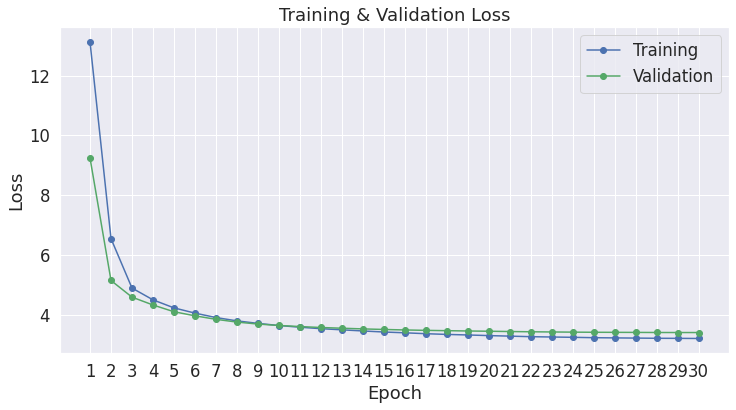

In [13]:
sns.set(style = 'darkgrid')
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (12,6)
plt.plot(df_stats['Training Loss'], 'b-o', label = 'Training')
plt.plot(df_stats['Valid Loss'], 'g-o', label = 'Validation')

plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(range(1,epochs+1))

plt.show()

In [11]:
GPU_NUM = 4 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU

test_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = 16)

t0=time.time()
predictions = []

model.eval()
for batch in tqdm(test_dataloader):
    b_input_ids = batch[0].to(device)
    b_attention_mask = batch[1].to(device)

    with torch.no_grad():        
        output = model.module.generate(input_ids=b_input_ids, attention_mask = b_attention_mask, num_beams=5, max_length=50, early_stopping=True)
    predictions.append(output)
    
validation_time = format_time(time.time() - t0)
print("Done", validation_time)

output = []
for i in range(len(predictions)):
    for j in range(len(predictions[i])):
        output.append(tokenizer.decode(predictions[i][j], skip_special_tokens = True))

submission = pd.read_csv('../dataset/abstractive_sample_submission_v2.csv')
submission.columns = ['id', 'summary']
submission['summary'] = output

submission.to_csv('../result/SUM_KoBART_base_4(2)_1e-4_30_fix-loss.csv', encoding='utf-8', index=False)


Done 0:21:37


In [24]:
torch.save(model, '../finetuned_model/SUM_KoBART_base_4(2)_1e-4_30_fix-loss.ckpt')

# calculate ROUGE 

In [8]:
model = torch.load('../finetuned_model/SUM_KoBART_base_4(2)_1e-4_30_fix-loss.ckpt')

In [9]:
import argparse
import pandas as pd
from tqdm import tqdm
from rouge_metric import Rouge

class RougeScorer:
    def __init__(self):
        self.rouge_evaluator = Rouge(
            metrics=["rouge-n", "rouge-l"],
            max_n=2,
            limit_length=True,
            length_limit=1000,
            length_limit_type="words",
            use_tokenizer=True,
            apply_avg=True,
            apply_best=False,
            alpha=0.5,  # Default F1_score
            weight_factor=1.2,
        )

    def compute_rouge(self, ref_df, hyp_df):
        #ref_df = pd.read_csv(ref_path)
        #hyp_df = pd.read_csv(hyp_path)
        hyp_df.iloc[:,1] = hyp_df.iloc[:,1].fillna(' ')
        ids = ref_df['id']
        hyp_df = hyp_df[hyp_df['id'].isin(ids)]
        hyp_df.index = ref_df.index

        ref_df = ref_df.sort_values(by=["id"])
        hyp_df = hyp_df.sort_values(by=["id"])
        ref_df["id"] = ref_df["id"].astype(int)
        hyp_df["id"] = hyp_df["id"].astype(int)

        hyps = [tuple(row) for row in hyp_df.values]
        refs = [tuple(row) for row in ref_df.values]

        reference_summaries = []
        generated_summaries = []

        for ref_tp, hyp_tp in zip(refs, hyps):
            ref_id, ref = ref_tp
            hyp_id, hyp = hyp_tp

            assert ref_id == hyp_id

            reference_summaries.append(ref)
            generated_summaries.append(hyp)

        scores = self.rouge_evaluator.get_scores(generated_summaries, reference_summaries)
        str_scores = self.format_rouge_scores(scores)
        #self.save_rouge_scores(str_scores)
        return str_scores

    def save_rouge_scores(self, str_scores):
        with open("rouge_scores.txt", "w") as output:
            output.write(str_scores)

    def format_rouge_scores(self, scores):
    	return "{:.3f},{:.3f},{:.3f}".format(
            scores["rouge-1"]["f"],
            scores["rouge-2"]["f"],
            scores["rouge-l"]["f"],
        )

In [16]:
labels = torch.cat(labels_list, axis=0)
torch.manual_seed(0)
dataset = TensorDataset(new_input_ids, new_attention_mask, labels)
train_size, val_size = round(len(train_data) * 0.9), round(len(train_data) * 0.1)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
test_dataset = TensorDataset(test_input_ids, test_attention_mask)

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(len(test_data)))

38,523 training samples
4,280 validation samples
9,987 test samples


In [16]:
predictions = []

GPU_NUM = 4 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU

for i in range(5): 
    with torch.no_grad():        
        output = model.module.generate(input_ids=val_dataset[i][0].cuda().unsqueeze(0),
                                       attention_mask = val_dataset[i][1].cuda().unsqueeze(0),
                                       num_beams=5, num_beam_groups=1, max_length=50, diversity_penalty =0.0, early_stopping=True)
    predictions.append(output)
    
output = []
for i in range(len(predictions)):
    for j in range(len(predictions[i])):
        output.append(tokenizer.decode(predictions[i][j], skip_special_tokens = True))


In [17]:
output

['부산 해운대 해운대·수영·동래구가 연내 조정대상지역에서 해제될 가능성이 커지고 있다. ',
 '부산지방기상청(청장 유희동)과 부산중구(구청장 윤종서)는 「대청큰마루터 기상사업」의 일환으로 양 기관이 협력하여 부산기상관측소 내에 조성한',
 '코미디언 조혜련이 공연 중 다리가 부러진 사연을 밝혀 화제가 되고 되고 있다.',
 '5월 행사 줄이어 이달만 국내외 행사 10건 열려 이달만 국내외 행사 10건 열려 3천600여 명 여수 방문 국내 최초 MICE 인증도시 여수가 MICE 행사를 잇달아 개최한다.',
 '올해 제3회째를 맞는 청산생선국수와 함께하는 민속씨름 대회가 오는 13-14일까지 청산면 교평리 체육공원일원에서 열린다.']

In [22]:
GPU_NUM = 4 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU

val_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = 16)
t0=time.time()
predictions = []

model.eval()
for batch in tqdm(val_dataloader):
    b_input_ids = batch[0].to(device)
    b_attention_mask = batch[1].to(device)

    with torch.no_grad():        
        output = model.module.generate(input_ids=b_input_ids, attention_mask = b_attention_mask, num_beams=8, max_length=100, early_stopping=True, )
    predictions.append(output)

validation_time = format_time(time.time() - t0)
print("Done", validation_time)

output = []
for i in range(len(predictions)):
    for j in range(len(predictions[i])):
        output.append(tokenizer.decode(predictions[i][j], skip_special_tokens = True))
        
t1=time.time()
print('total inference time: {}'.format(format_time(t1-t0)))
print('average inference time: {}'.format((t1-t0)/len(output)))

100%|██████████| 268/268 [13:16<00:00,  2.97s/it]


Done 0:13:16
total inference time: 0:13:17
average inference time: 0.18614409487938213


In [23]:
submission = pd.read_csv('../dataset/abstractive_sample_submission_v2.csv')
submission = submission[:4280]
submission.columns = ['id', 'summary']
submission['summary'] = output
submission['id'] = range(4280)

In [24]:
label = []
for i in range(len(val_dataset)):
    label.append(tokenizer.decode(val_dataset[i][2], skip_special_tokens = True))

label_df = pd.read_csv('../dataset/abstractive_sample_submission_v2.csv')
label_df = label_df[:4280]
label_df.columns = ['id', 'summary']
label_df['summary'] = label
label_df['id'] = range(4280)

In [21]:
# max_length=50, seed=0
rouge = RougeScorer()
rouge.compute_rouge(label_df, submission)

'0.404,0.257,0.343'

In [25]:
# max_length=100, seed=0
rouge = RougeScorer()
rouge.compute_rouge(label_df, submission)

'0.416,0.267,0.352'

In [67]:
# 실험시 사용한 데이터셋
rouge.compute_rouge(label_df, submission)

'0.409,0.261,0.345'

In [68]:
for i in range(10):
    print('예측 문장: ', output[i])
    print('정답 문장: ', tokenizer.decode(val_dataset[i][2], skip_special_tokens=True), '\n')

예측 문장:  주민체감형 디지털 사회혁신 활성화 사업 선정 국비 1억5천 확보“ICT기반 돌봄 시스템 구축” 신안군 주민체감형 디지털 사화혁신 활성화 사업 개요도
정답 문장:  전남 신안군이 행정안전부에서 공모하는 ‘주민체감형 디지털 사회혁신 활성화 사업’에 선정돼 국비 1억 5천만원을 지원받아 ‘ICT기반 1004섬 생활밀착 돌봄 시스템’을 구축하고 군민의 복지체감도 향상을 위한 사업을 추진한다. 

예측 문장:  행정안전위원회는 4일 상임위원회를 열고 부처 업무보고를 받거나 법안 심사 등 각종 안건을 처리했다. 행정안전위원회는 이날 전체회의를 열고 진영 행정안전부 장관 후보자에 대한 인사청문 경과보고서를 채택했다.
정답 문장:  국회는 4일 상임위원회를 열고 부처 업무보고를 받거나 법안 심사 등의 여러가지 안건을 처리한 가운데, 행정안전위원회는 진영 행정안전부 장관 후보자에 대한 인사청문 경과보고서를 채택했으며, 법제사법위원회는 9일과 10일에 문형배·이미선 헌법재판소 재판관 후보자에 대한 인사청문회를  각각 진행하기로 하였다고 전해졌다.
 

예측 문장:  양승조 충남도지사는 24일(현지시각) 폴란드 비엘코폴스카주 코닌시를 찾아 시 관계자 등과 에너지 전환 정책 등을 주제로 간담회를 갖고 충남도내 석탄화력 현황과 대책에 대해 발표하고 있다.
정답 문장:  양승조 충남도지사는 앞으로 200년 간 사용할 수 있는 석탄을 보유한 '석탄 강국' 폴란드가 탈석탄을 위해 다방면으로 힘쓰고 있음을 살피고 6박8일간의 유럽 출장 일정을 마무리하고 귀국했다.  

예측 문장:  광주 소속 선수단은 나폴리 하계U대회 포상금 수여식에 참석한 광주 소속 선수단이 파이팅을 외치고 있다.
정답 문장:  지난 24일 체육회관 중회의실에서 광주시체육회는 2019 제 30회 나폴리 하계유니버시아드 대회에서 금2·은1·동5개의 메달을 획득한 광주시체육회 소속 임원과 선수에게 입상 포상금을 전달했다.   

예측 문장:  인천시, 미추홀구 등 3곳에 오픈 이웃들 모여 정보 공유·체험학습 